In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
double_train = pd.read_csv("../final_dataset/double/double_train.csv")
double_valid = pd.read_csv("../final_dataset/double/double_valid.csv")
double_test = pd.read_csv("../final_dataset/double/double_test.csv")

In [3]:
feature_columns = double_train.columns[1:-1]

X_double_train = double_train[feature_columns].values
Y_double_train = double_train['Label'].values

X_double_valid = double_valid[feature_columns].values
Y_double_valid = double_valid['Label'].values

X_double_test = double_test[feature_columns].values
Y_double_test = double_test['Label'].values

In [4]:
double_scaler = StandardScaler()

X_double_train = double_scaler.fit_transform(X_double_train)
X_double_valid = double_scaler.transform(X_double_valid)
X_double_test = double_scaler.transform(X_double_test)

Y_double_train = Y_double_train.astype(int)
Y_double_valid = Y_double_valid.astype(int)
Y_double_test = Y_double_test.astype(int)

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score

def print_classification_result(result_df, model_name, data_type, y_true, y_pred, y_pred_prob):
    # 정확도
    accuracy = accuracy_score(y_true, y_pred)
    
    # 정밀도 (단일 스칼라 값)
    precision = precision_score(y_true, y_pred, average='weighted')  
    
    # 재현율 (단일 스칼라 값)
    recall = recall_score(y_true, y_pred, average='weighted')  
    
    # F1 점수 (단일 스칼라 값)
    f1 = f1_score(y_true, y_pred, average='weighted')  
    
    # AUC Score 계산
    auc_score = roc_auc_score(y_true, y_pred_prob[:, 1])
    
    # PR Score 계산
    pr_score = average_precision_score(y_true, y_pred_prob[:, 1])
    
    # 결과 저장 (각 지표의 단일 값 저장)
    result_df.loc[len(result_df)] = [
        model_name,
        data_type,
        accuracy,
        precision,
        recall,
        f1,
        auc_score,
        pr_score
    ]


In [6]:
from tensorflow import keras
import tensorflow_addons as tfa

# Transformer 모델에 들어가는 encoder 첫번째
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x1 = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x2 = tfa.layers.InstanceNormalization()(x)
    x = (0.7 * x1) + (0.3 * x2)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="LeakyReLU")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x1 = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x2 = tfa.layers.InstanceNormalization()(x)
    x = (0.7 * x1) + (0.3 * x2)
    return x + res


# Transformer 모델에 들어가는 encoder 두번째
def transformer_encoder2(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)

    x = keras.layers.Dropout(dropout)(x)
    x1 = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x2 = tfa.layers.InstanceNormalization()(x)
    x = (0.7 * x1) + (0.3 * x2)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="LeakyReLU")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x1 = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x2 = tfa.layers.InstanceNormalization()(x)
    x = (0.7 * x1) + (0.3 * x2)
    return x + res


# Transformer 모델 설계 부분
def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
        n_classes=1,  # n_classes 변수를 함수 내로 이동
):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for _ in range(num_transformer_blocks):
        x1 = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    for _ in range(num_transformer_blocks):
        x2 = transformer_encoder2(x, head_size, num_heads, ff_dim, dropout)
    
    x = (0.5 * x1) + (0.5 * x2)
    x = keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="LeakyReLU")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    
    outputs = keras.layers.Dense(n_classes, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)


2024-09-20 22:04:51.867087: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-20 22:04:51.933461: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 22:04:51.933526: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 22:04:51.933537: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 22:04:51.947289: I tensorflow/core/platform/cpu_feature_g

In [7]:
# 데이터 형태 맞추기
X_double_train = X_double_train.reshape((X_double_train.shape[0], X_double_train.shape[1], 1))
X_double_valid = X_double_valid.reshape((X_double_valid.shape[0], X_double_valid.shape[1], 1))
X_double_test= X_double_test.reshape((X_double_test.shape[0], X_double_test.shape[1], 1))

In [8]:
input_shape = (26,1)
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

2024-09-20 22:04:54.966367: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31139 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:b3:00.0, compute capability: 7.0


In [9]:
from tensorflow.keras.optimizers import Adam

# 모델 컴파일
optimizer = Adam(learning_rate=0.001)  
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) 

# 모델 학습
history = model.fit(X_double_train, Y_double_train, epochs=50, batch_size=32, validation_data=(X_double_valid, Y_double_valid))

Epoch 1/50


2024-09-20 22:05:06.885707: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-09-20 22:05:08.311050: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc2984aff70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-20 22:05:08.311104: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-09-20 22:05:08.319534: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-20 22:05:08.512861: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


102/102 [==============================] - 20s 30ms/step - loss: 0.4218 - accuracy: 0.8027 - val_loss: 0.3334 - val_accuracy: 0.8412
Epoch 2/50
102/102 [==============================] - 2s 23ms/step - loss: 0.3424 - accuracy: 0.8447 - val_loss: 0.3059 - val_accuracy: 0.8550
Epoch 3/50
102/102 [==============================] - 2s 21ms/step - loss: 0.3070 - accuracy: 0.8570 - val_loss: 0.2716 - val_accuracy: 0.8898
Epoch 4/50
102/102 [==============================] - 2s 21ms/step - loss: 0.2824 - accuracy: 0.8788 - val_loss: 0.2606 - val_accuracy: 0.8903
Epoch 5/50
102/102 [==============================] - 2s 23ms/step - loss: 0.2836 - accuracy: 0.8788 - val_loss: 0.2528 - val_accuracy: 0.8956
Epoch 6/50
102/102 [==============================] - 2s 19ms/step - loss: 0.2687 - accuracy: 0.8862 - val_loss: 0.2507 - val_accuracy: 0.8935
Epoch 7/50
102/102 [==============================] - 2s 21ms/step - loss: 0.2501 - accuracy: 0.8984 - val_loss: 0.2546 - val_accuracy: 0.8892
Epoch 8/5

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

# 예측
y_pred = model.predict(X_double_train)

# 예측 확률을 이진 레이블로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(Y_double_train, y_pred_binary)

# Weighted Precision
weighted_precision = precision_score(Y_double_train, y_pred_binary)

# Weighted Recall
weighted_recall = recall_score(Y_double_train, y_pred_binary)

# Weighted F1 Score
weighted_f1 = f1_score(Y_double_train, y_pred_binary)

# AUC Score
auc_score = roc_auc_score(Y_double_train, y_pred)

# PR Curve의 평균 정밀도 점수 계산
pr_score = average_precision_score(Y_double_train, y_pred)

print("---------------------------train--------------------------")
print(f'Accuracy: {accuracy}')
print(f'Precision: {weighted_precision}')
print(f'Recall: {weighted_recall}')
print(f'F1 Score: {weighted_f1}')
print(f'AUC Score: {auc_score}')
print(f'PR Score: {pr_score}')


102/102 [==============================] - 1s 5ms/step
---------------------------train--------------------------
Accuracy: 0.9404725375882173
Precision: 0.9345692475463467
Recall: 0.9586129753914989
F1 Score: 0.9464384318056323
AUC Score: 0.9887553856284893
PR Score: 0.9910614164080787


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score

# 예측
y_pred = model.predict(X_double_valid)

# 예측 확률을 이진 레이블로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(Y_double_valid, y_pred_binary)

# Weighted Precision
weighted_precision = precision_score(Y_double_valid, y_pred_binary)

# Weighted Recall
weighted_recall = recall_score(Y_double_valid, y_pred_binary)

# Weighted F1 Score
weighted_f1 = f1_score(Y_double_valid, y_pred_binary)

# AUC Score
auc_score = roc_auc_score(Y_double_valid, y_pred)

# PR Curve의 평균 정밀도 점수 계산
pr_score = average_precision_score(Y_double_valid, y_pred)

print("---------------------------valid--------------------------")
print(f'Accuracy: {accuracy}')
print(f'Precision: {weighted_precision}')
print(f'Recall: {weighted_recall}')
print(f'F1 Score: {weighted_f1}')
print(f'AUC Score: {auc_score}')
print(f'PR Score: {pr_score}')


60/60 [==============================] - 0s 6ms/step
---------------------------valid--------------------------
Accuracy: 0.9066455696202531
Precision: 0.9168377823408624
Recall: 0.9029322548028311
F1 Score: 0.9098318899643403
AUC Score: 0.9724577853633631
PR Score: 0.9757877725751107


In [25]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

# 예측
y_pred = model.predict(X_double_test)

# 예측 확률을 이진 레이블로 변환
y_pred_binary = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(Y_double_test, y_pred_binary)

# Weighted Precision
weighted_precision = precision_score(Y_double_test, y_pred_binary)

# Weighted Recall
weighted_recall = recall_score(Y_double_test, y_pred_binary)

# Weighted F1 Score
weighted_f1 = f1_score(Y_double_test, y_pred_binary)

# AUC Score
auc_score = roc_auc_score(Y_double_test, y_pred)

# PR Curve의 평균 정밀도 점수 계산
pr_score = average_precision_score(Y_double_test, y_pred)

print("---------------------------test--------------------------")
print(f'Accuracy: {accuracy}')
print(f'Precision: {weighted_precision}')
print(f'Recall: {weighted_recall}')
print(f'F1 Score: {weighted_f1}')
print(f'AUC Score: {auc_score}')
print(f'PR Score: {pr_score}')


67/67 [==============================] - 0s 6ms/step
---------------------------test--------------------------
Accuracy: 0.8310523831996225
Precision: 0.8219284603421462
Recall: 0.8912310286677909
F1 Score: 0.8551779935275081
AUC Score: 0.9327903786404083
PR Score: 0.9491841282095641


In [26]:
# 혼동 행렬 시각화를 위한 함수 정의
def plot_confusion_matrix(model_name, true_labels, predictions):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

67/67 [==============================] - 1s 7ms/step


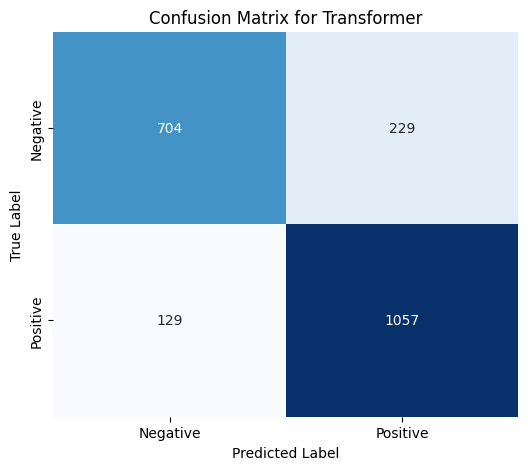

In [27]:
# 테스트 데이터에 대한 예측
test_pred_prob = model.predict(X_double_test)  # 확률값 반환
    
# 확률을 클래스 레이블로 변환 (0.5 임계값 사용)
test_pred = (test_pred_prob >= 0.5).astype(int)

# 혼동 행렬 시각화
plot_confusion_matrix("Transformer", Y_double_test, test_pred)

In [13]:
transformer_pred_prob = model.predict(X_double_test)
np.save('../ml_models/pred_prob/transformer_pred_prob_double.npy', transformer_pred_prob)  # .npy 파일로 저장

67/67 [==============================] - 0s 4ms/step


In [14]:
test_1 = pd.read_csv("../final_dataset/each_test/double/A_D_11.csv")
test_2 = pd.read_csv("../final_dataset/each_test/double/B_D_11.csv")
test_3 = pd.read_csv("../final_dataset/each_test/double/C_D_11.csv")
test_4 = pd.read_csv("../final_dataset/each_test/double/D_D_11.csv")
test_5 = pd.read_csv("../final_dataset/each_test/double/E_D_11.csv")
test_6 = pd.read_csv("../final_dataset/each_test/double/F_D_11.csv")
test_7 = pd.read_csv("../final_dataset/each_test/double/G_D_11.csv")
test_8 = pd.read_csv("../final_dataset/each_test/double/H_D_11.csv")
test_9 = pd.read_csv("../final_dataset/each_test/double/I_D_11.csv")
test_10 = pd.read_csv("../final_dataset/each_test/double/J_D_11.csv")

In [15]:
# feature_columns 정의
feature_columns = test_1.columns[1:-1]  # 모든 test 파일에 동일한 컬럼 구조라고 가정

# 각 test 데이터에 대해 feature와 label 추출
X_test_1 = test_1[feature_columns].values
Y_test_1 = test_1['Label'].values

X_test_2 = test_2[feature_columns].values
Y_test_2 = test_2['Label'].values

X_test_3 = test_3[feature_columns].values
Y_test_3 = test_3['Label'].values

X_test_4 = test_4[feature_columns].values
Y_test_4 = test_4['Label'].values

X_test_5 = test_5[feature_columns].values
Y_test_5 = test_5['Label'].values

X_test_6 = test_6[feature_columns].values
Y_test_6 = test_6['Label'].values

X_test_7 = test_7[feature_columns].values
Y_test_7 = test_7['Label'].values

X_test_8 = test_8[feature_columns].values
Y_test_8 = test_8['Label'].values

X_test_9 = test_9[feature_columns].values
Y_test_9 = test_9['Label'].values

X_test_10 = test_10[feature_columns].values
Y_test_10 = test_10['Label'].values

In [16]:
# Scaler 적용 및 데이터 형 변환을 처리하는 함수 정의
def process_test_data(X_test, Y_test, scaler):
    # 데이터 스케일링
    X_test_scaled = scaler.transform(X_test)
    
    # int 타입으로 변환
    Y_test = Y_test.astype(int)
    
    return X_test_scaled, Y_test


In [17]:
# X_single_train, X_single_valid, X_single_test의 스케일러로 test 데이터 변환
X_test_1, Y_test_1 = process_test_data(X_test_1, Y_test_1, double_scaler)
X_test_2, Y_test_2 = process_test_data(X_test_2, Y_test_2, double_scaler)
X_test_3, Y_test_3 = process_test_data(X_test_3, Y_test_3, double_scaler)
X_test_4, Y_test_4 = process_test_data(X_test_4, Y_test_4, double_scaler)
X_test_5, Y_test_5 = process_test_data(X_test_5, Y_test_5, double_scaler)
X_test_6, Y_test_6 = process_test_data(X_test_6, Y_test_6, double_scaler)
X_test_7, Y_test_7 = process_test_data(X_test_7, Y_test_7, double_scaler)
X_test_8, Y_test_8 = process_test_data(X_test_8, Y_test_8, double_scaler)
X_test_9, Y_test_9 = process_test_data(X_test_9, Y_test_9, double_scaler)
X_test_10, Y_test_10 = process_test_data(X_test_10, Y_test_10, double_scaler)

In [18]:
import os

# 모델을 사용하여 예측 및 점프수 계산을 반복적으로 수행하는 함수
def process_and_visualize(test_data, Y_test, model, model_name, test_name, output_dir):
    
    test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
    # 테스트 데이터에 대한 예측
    predictions = model.predict(test_data)
    
    # 이동 평균을 계산하여 예측값 부드럽게 만들기
    smoothed_predictions = np.convolve(predictions.squeeze(), np.ones(5)/5, mode='same')
    
    # 테스트 데이터에 대한 예측 결과를 바이너리 형태로 변환
    binary_predictions = (smoothed_predictions > 0.5).astype(int)
    
    # 0에서 1로 바뀌는 구간에서 줄넘기 개수 카운트
    jump_count = np.sum(np.diff(binary_predictions.flatten()) > 0)
    
    # 예측 결과 시각화
    plt.plot(Y_test, label='Actual')
    plt.plot(binary_predictions.flatten(), label='Predicted')
    plt.title(f'Actual vs Predicted for {test_name} player using {model_name}')  
    plt.xlabel('Data Point')
    plt.ylabel('Label')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'{model_name}_predictions_{test_name}.png'))
    plt.close()  # 현재 플롯 닫기



In [19]:
test_data_list = [
    (X_test_1, Y_test_1, "A"),
    (X_test_2, Y_test_2, "B"),
    (X_test_3, Y_test_3, "C"),
    (X_test_4, Y_test_4, "D"),
    (X_test_5, Y_test_5, "E"),
    (X_test_6, Y_test_6, "F"),
    (X_test_7, Y_test_7, "G"),
    (X_test_8, Y_test_8, "H"),
    (X_test_9, Y_test_9, "I"),
    (X_test_10, Y_test_10, "J")
]

In [20]:
# 결과를 저장할 디렉토리 생성
output_dir = '../double_model_predictions'

  
# 각 테스트 데이터에 대해 process_and_visualize 호출
for test_data, Y_test, test_name in test_data_list:
    # 예측 결과 시각화 및 이미지로 저장
    process_and_visualize(test_data, Y_test, model, "Transformer", test_name, output_dir)
        
        

7/7 [==============================] - 0s 10ms/step


In [21]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# 3D 배열을 2D 배열로 변환
X_double_test_reshaped = X_double_test.reshape(X_double_test.shape[0], -1)  # (n_samples, n_timesteps * n_features)

def transformer_predict(X):
    # X가 2D 배열일 경우 3D 배열로 변환
    X_reshaped = np.expand_dims(X, axis=2)  # (n_samples, n_features)에서 (n_samples, n_features, 1)로 변환
    return model.predict(X_reshaped)

# KMeans를 사용하여 배경 데이터 샘플링
background_samples = shap.kmeans(X_double_test_reshaped, k=20)  # K=100으로 샘플 수를 줄임

# KernelExplainer 생성
explainer = shap.KernelExplainer(transformer_predict, background_samples)

# 테스트 데이터에 대한 SHAP 값 추출
shap_values = explainer.shap_values(X_double_test_reshaped, nsamples=100)



/root/anaconda3/envs/jw_tensorflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 [==============================] - 0s 77ms/step


  0%|          | 0/2119 [00:00<?, ?it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 1/2119 [00:00<31:41,  1.11it/s]

63/63 [==============================] - 0s 4ms/step


  0%|          | 2/2119 [00:01<26:22,  1.34it/s]

63/63 [==============================] - 0s 4ms/step


  0%|          | 3/2119 [00:02<32:03,  1.10it/s]

63/63 [==============================] - 0s 4ms/step


  0%|          | 4/2119 [00:03<32:33,  1.08it/s]

63/63 [==============================] - 0s 4ms/step


  0%|          | 5/2119 [00:04<32:12,  1.09it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 6/2119 [00:05<32:33,  1.08it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 7/2119 [00:06<32:22,  1.09it/s]

63/63 [==============================] - 0s 3ms/step


  0%|          | 8/2119 [00:06<27:57,  1.26it/s]

63/63 [==============================] - 0s 5ms/step


  0%|          | 9/2119 [00:07<29:21,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


  0%|          | 10/2119 [00:08<29:28,  1.19it/s]

63/63 [==============================] - 0s 3ms/step


  1%|          | 11/2119 [00:09<26:23,  1.33it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 12/2119 [00:10<27:22,  1.28it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 13/2119 [00:10<25:11,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 14/2119 [00:11<27:22,  1.28it/s]

63/63 [==============================] - 0s 3ms/step


  1%|          | 15/2119 [00:12<24:54,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 16/2119 [00:12<22:38,  1.55it/s]

63/63 [==============================] - 0s 6ms/step


  1%|          | 17/2119 [00:13<24:53,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 18/2119 [00:14<27:26,  1.28it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 19/2119 [00:15<28:18,  1.24it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 20/2119 [00:16<29:22,  1.19it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 21/2119 [00:16<27:54,  1.25it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 22/2119 [00:17<28:33,  1.22it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 23/2119 [00:18<29:29,  1.18it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 24/2119 [00:19<26:21,  1.32it/s]

63/63 [==============================] - 0s 4ms/step


  1%|          | 25/2119 [00:19<23:56,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


  1%|          | 26/2119 [00:20<26:08,  1.33it/s]

63/63 [==============================] - 0s 4ms/step


  1%|▏         | 27/2119 [00:21<27:26,  1.27it/s]

63/63 [==============================] - 0s 5ms/step


  1%|▏         | 28/2119 [00:22<28:22,  1.23it/s]

63/63 [==============================] - 0s 4ms/step


  1%|▏         | 29/2119 [00:22<25:28,  1.37it/s]

63/63 [==============================] - 0s 4ms/step


  1%|▏         | 30/2119 [00:23<26:44,  1.30it/s]

63/63 [==============================] - 0s 3ms/step


  1%|▏         | 31/2119 [00:24<24:19,  1.43it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 32/2119 [00:24<22:29,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 33/2119 [00:25<21:24,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 34/2119 [00:25<21:28,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 35/2119 [00:26<24:31,  1.42it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 36/2119 [00:27<26:08,  1.33it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 37/2119 [00:28<24:21,  1.42it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 38/2119 [00:29<26:29,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 39/2119 [00:29<24:34,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 40/2119 [00:30<27:06,  1.28it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 41/2119 [00:31<24:37,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 42/2119 [00:32<26:53,  1.29it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 43/2119 [00:32<24:37,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 44/2119 [00:33<23:33,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 45/2119 [00:34<25:45,  1.34it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 46/2119 [00:35<26:43,  1.29it/s]

63/63 [==============================] - 0s 5ms/step


  2%|▏         | 47/2119 [00:36<28:11,  1.23it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 48/2119 [00:36<28:51,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 49/2119 [00:37<28:59,  1.19it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 50/2119 [00:38<25:51,  1.33it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 51/2119 [00:38<23:22,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


  2%|▏         | 52/2119 [00:39<25:07,  1.37it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 53/2119 [00:40<23:19,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 54/2119 [00:41<25:09,  1.37it/s]

63/63 [==============================] - 0s 6ms/step


  3%|▎         | 55/2119 [00:41<24:33,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 56/2119 [00:42<26:25,  1.30it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 57/2119 [00:43<25:00,  1.37it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 58/2119 [00:43<23:39,  1.45it/s]

63/63 [==============================] - 0s 3ms/step


  3%|▎         | 59/2119 [00:44<21:54,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 60/2119 [00:45<21:09,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 61/2119 [00:45<21:11,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 62/2119 [00:46<24:26,  1.40it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 63/2119 [00:47<27:16,  1.26it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 64/2119 [00:48<27:58,  1.22it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 65/2119 [00:49<28:51,  1.19it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 66/2119 [00:50<29:18,  1.17it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 67/2119 [00:51<30:50,  1.11it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 68/2119 [00:51<27:27,  1.25it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 69/2119 [00:52<26:38,  1.28it/s]

63/63 [==============================] - 0s 6ms/step


  3%|▎         | 70/2119 [00:53<27:48,  1.23it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 71/2119 [00:54<29:51,  1.14it/s]

63/63 [==============================] - 0s 4ms/step


  3%|▎         | 72/2119 [00:55<29:37,  1.15it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 73/2119 [00:56<30:35,  1.11it/s]

63/63 [==============================] - 0s 5ms/step


  3%|▎         | 74/2119 [00:57<30:47,  1.11it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▎         | 75/2119 [00:58<30:53,  1.10it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▎         | 76/2119 [00:58<27:05,  1.26it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▎         | 77/2119 [00:59<29:17,  1.16it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▎         | 78/2119 [01:00<30:13,  1.13it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▎         | 79/2119 [01:01<27:49,  1.22it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 80/2119 [01:02<28:51,  1.18it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 81/2119 [01:02<26:09,  1.30it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 82/2119 [01:03<23:14,  1.46it/s]

63/63 [==============================] - 0s 3ms/step


  4%|▍         | 83/2119 [01:03<21:25,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 84/2119 [01:04<23:55,  1.42it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 85/2119 [01:05<27:19,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▍         | 86/2119 [01:06<28:01,  1.21it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 87/2119 [01:07<28:11,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 88/2119 [01:08<29:42,  1.14it/s]

63/63 [==============================] - 0s 3ms/step


  4%|▍         | 89/2119 [01:08<26:23,  1.28it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 90/2119 [01:09<23:57,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 91/2119 [01:10<26:07,  1.29it/s]

63/63 [==============================] - 0s 5ms/step


  4%|▍         | 92/2119 [01:11<27:12,  1.24it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 93/2119 [01:12<28:11,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 94/2119 [01:13<28:59,  1.16it/s]

63/63 [==============================] - 0s 4ms/step


  4%|▍         | 95/2119 [01:13<28:54,  1.17it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▍         | 96/2119 [01:14<30:46,  1.10it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 97/2119 [01:15<27:05,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▍         | 98/2119 [01:16<28:10,  1.20it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▍         | 99/2119 [01:17<28:17,  1.19it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 100/2119 [01:17<25:05,  1.34it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 101/2119 [01:18<22:57,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 102/2119 [01:19<25:37,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 103/2119 [01:19<24:15,  1.38it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 104/2119 [01:20<27:02,  1.24it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▍         | 105/2119 [01:21<27:46,  1.21it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▌         | 106/2119 [01:22<28:22,  1.18it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▌         | 107/2119 [01:23<29:56,  1.12it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 108/2119 [01:24<26:19,  1.27it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 109/2119 [01:24<23:42,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 110/2119 [01:25<22:01,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 111/2119 [01:25<20:42,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▌         | 112/2119 [01:26<25:21,  1.32it/s]

63/63 [==============================] - 0s 6ms/step


  5%|▌         | 113/2119 [01:27<26:19,  1.27it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 114/2119 [01:28<27:27,  1.22it/s]

63/63 [==============================] - 0s 4ms/step


  5%|▌         | 115/2119 [01:29<28:53,  1.16it/s]

63/63 [==============================] - 0s 5ms/step


  5%|▌         | 116/2119 [01:30<26:15,  1.27it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 117/2119 [01:30<23:47,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 118/2119 [01:31<25:30,  1.31it/s]

63/63 [==============================] - 0s 6ms/step


  6%|▌         | 119/2119 [01:32<26:06,  1.28it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 120/2119 [01:33<27:12,  1.22it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 121/2119 [01:34<27:59,  1.19it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 122/2119 [01:34<26:11,  1.27it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 123/2119 [01:35<28:15,  1.18it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 124/2119 [01:36<25:42,  1.29it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 125/2119 [01:37<27:25,  1.21it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 126/2119 [01:38<28:39,  1.16it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▌         | 127/2119 [01:39<27:46,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 128/2119 [01:40<29:13,  1.14it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 129/2119 [01:41<30:26,  1.09it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 130/2119 [01:42<31:02,  1.07it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 131/2119 [01:43<30:48,  1.08it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▌         | 132/2119 [01:43<27:18,  1.21it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▋         | 133/2119 [01:44<27:56,  1.18it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▋         | 134/2119 [01:45<28:52,  1.15it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▋         | 135/2119 [01:46<26:33,  1.24it/s]

63/63 [==============================] - 0s 4ms/step


  6%|▋         | 136/2119 [01:46<24:26,  1.35it/s]

63/63 [==============================] - 0s 5ms/step


  6%|▋         | 137/2119 [01:47<22:47,  1.45it/s]

63/63 [==============================] - 0s 6ms/step


  7%|▋         | 138/2119 [01:47<22:17,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 139/2119 [01:48<25:27,  1.30it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 140/2119 [01:49<25:09,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 141/2119 [01:50<23:05,  1.43it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 142/2119 [01:51<24:40,  1.34it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 143/2119 [01:51<23:38,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 144/2119 [01:52<21:53,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 145/2119 [01:53<25:03,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 146/2119 [01:54<26:12,  1.25it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 147/2119 [01:54<24:11,  1.36it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 148/2119 [01:55<22:26,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 149/2119 [01:56<24:30,  1.34it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 150/2119 [01:56<23:16,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 151/2119 [01:58<29:09,  1.12it/s]

63/63 [==============================] - 0s 7ms/step


  7%|▋         | 152/2119 [01:59<29:05,  1.13it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 153/2119 [01:59<25:58,  1.26it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 154/2119 [02:00<26:27,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 155/2119 [02:01<27:01,  1.21it/s]

63/63 [==============================] - 0s 5ms/step


  7%|▋         | 156/2119 [02:01<25:07,  1.30it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 157/2119 [02:02<24:54,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


  7%|▋         | 158/2119 [02:03<23:40,  1.38it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 159/2119 [02:03<22:05,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 160/2119 [02:04<20:58,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 161/2119 [02:05<24:50,  1.31it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 162/2119 [02:06<23:30,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 163/2119 [02:06<23:10,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 164/2119 [02:07<27:44,  1.17it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 165/2119 [02:08<28:59,  1.12it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 166/2119 [02:09<26:05,  1.25it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 167/2119 [02:10<26:56,  1.21it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 168/2119 [02:10<23:58,  1.36it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 169/2119 [02:11<21:46,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 170/2119 [02:12<21:11,  1.53it/s]

63/63 [==============================] - 0s 3ms/step


  8%|▊         | 171/2119 [02:12<19:55,  1.63it/s]

63/63 [==============================] - 0s 3ms/step


  8%|▊         | 172/2119 [02:13<18:54,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 173/2119 [02:13<21:42,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 174/2119 [02:14<24:32,  1.32it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 175/2119 [02:15<26:21,  1.23it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 176/2119 [02:16<28:02,  1.15it/s]

63/63 [==============================] - 0s 5ms/step


  8%|▊         | 177/2119 [02:17<28:36,  1.13it/s]

63/63 [==============================] - 0s 3ms/step


  8%|▊         | 178/2119 [02:18<26:17,  1.23it/s]

63/63 [==============================] - 0s 3ms/step


  8%|▊         | 179/2119 [02:19<24:13,  1.33it/s]

63/63 [==============================] - 0s 4ms/step


  8%|▊         | 180/2119 [02:19<25:37,  1.26it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▊         | 181/2119 [02:20<26:43,  1.21it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▊         | 182/2119 [02:21<27:30,  1.17it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▊         | 183/2119 [02:22<29:19,  1.10it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▊         | 184/2119 [02:23<30:08,  1.07it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▊         | 185/2119 [02:24<26:24,  1.22it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 186/2119 [02:25<26:37,  1.21it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 187/2119 [02:26<27:26,  1.17it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 188/2119 [02:26<27:46,  1.16it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 189/2119 [02:27<24:27,  1.32it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 190/2119 [02:28<22:17,  1.44it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 191/2119 [02:29<26:11,  1.23it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 192/2119 [02:29<24:40,  1.30it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 193/2119 [02:30<23:04,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 194/2119 [02:31<22:02,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


  9%|▉         | 195/2119 [02:31<20:46,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 196/2119 [02:32<20:34,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 197/2119 [02:32<20:29,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 198/2119 [02:33<23:47,  1.35it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 199/2119 [02:34<25:42,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 200/2119 [02:35<26:42,  1.20it/s]

63/63 [==============================] - 0s 5ms/step


  9%|▉         | 201/2119 [02:36<28:05,  1.14it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 202/2119 [02:37<25:25,  1.26it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 203/2119 [02:37<24:09,  1.32it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 204/2119 [02:38<26:14,  1.22it/s]

63/63 [==============================] - 0s 5ms/step


 10%|▉         | 205/2119 [02:39<26:15,  1.21it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 206/2119 [02:40<27:13,  1.17it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 207/2119 [02:41<27:24,  1.16it/s]

63/63 [==============================] - 0s 5ms/step


 10%|▉         | 208/2119 [02:42<29:44,  1.07it/s]

63/63 [==============================] - 0s 5ms/step


 10%|▉         | 209/2119 [02:43<30:39,  1.04it/s]

63/63 [==============================] - 0s 6ms/step


 10%|▉         | 210/2119 [02:44<27:03,  1.18it/s]

63/63 [==============================] - 0s 4ms/step


 10%|▉         | 211/2119 [02:44<24:11,  1.31it/s]

63/63 [==============================] - 0s 5ms/step


 10%|█         | 212/2119 [02:45<25:13,  1.26it/s]

63/63 [==============================] - 0s 5ms/step


 10%|█         | 213/2119 [02:46<23:24,  1.36it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 214/2119 [02:46<21:49,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


 10%|█         | 215/2119 [02:47<24:03,  1.32it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 216/2119 [02:48<25:18,  1.25it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 217/2119 [02:49<26:12,  1.21it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 218/2119 [02:50<26:48,  1.18it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 219/2119 [02:51<26:47,  1.18it/s]

63/63 [==============================] - 0s 5ms/step


 10%|█         | 220/2119 [02:51<24:41,  1.28it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 221/2119 [02:52<26:20,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


 10%|█         | 222/2119 [02:53<26:48,  1.18it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 223/2119 [02:54<27:32,  1.15it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 224/2119 [02:55<25:04,  1.26it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 225/2119 [02:56<25:51,  1.22it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 226/2119 [02:56<24:00,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 227/2119 [02:57<26:52,  1.17it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 228/2119 [02:58<24:25,  1.29it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 229/2119 [02:59<25:51,  1.22it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 230/2119 [02:59<23:35,  1.33it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 231/2119 [03:00<22:22,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 232/2119 [03:01<24:00,  1.31it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 233/2119 [03:02<22:36,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 234/2119 [03:02<20:22,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█         | 235/2119 [03:03<22:44,  1.38it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 236/2119 [03:04<23:45,  1.32it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 237/2119 [03:05<25:35,  1.23it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█         | 238/2119 [03:06<26:45,  1.17it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█▏        | 239/2119 [03:07<27:25,  1.14it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█▏        | 240/2119 [03:07<24:36,  1.27it/s]

63/63 [==============================] - 0s 4ms/step


 11%|█▏        | 241/2119 [03:08<26:06,  1.20it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█▏        | 242/2119 [03:09<27:29,  1.14it/s]

63/63 [==============================] - 0s 5ms/step


 11%|█▏        | 243/2119 [03:10<28:51,  1.08it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 244/2119 [03:11<29:25,  1.06it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 245/2119 [03:12<26:09,  1.19it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 246/2119 [03:13<26:46,  1.17it/s]

63/63 [==============================] - 0s 3ms/step


 12%|█▏        | 247/2119 [03:13<23:56,  1.30it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 248/2119 [03:14<21:40,  1.44it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 249/2119 [03:15<22:24,  1.39it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 250/2119 [03:15<22:27,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 251/2119 [03:16<20:37,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 252/2119 [03:17<23:39,  1.32it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 253/2119 [03:18<24:47,  1.25it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 254/2119 [03:19<25:26,  1.22it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 255/2119 [03:19<25:51,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 256/2119 [03:20<24:05,  1.29it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 257/2119 [03:21<25:02,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 258/2119 [03:22<26:13,  1.18it/s]

63/63 [==============================] - 0s 5ms/step


 12%|█▏        | 259/2119 [03:23<26:28,  1.17it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 260/2119 [03:24<26:13,  1.18it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 261/2119 [03:24<23:21,  1.33it/s]

63/63 [==============================] - 0s 3ms/step


 12%|█▏        | 262/2119 [03:25<21:37,  1.43it/s]

63/63 [==============================] - 0s 3ms/step


 12%|█▏        | 263/2119 [03:25<19:57,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 12%|█▏        | 264/2119 [03:26<21:55,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 265/2119 [03:27<22:04,  1.40it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 266/2119 [03:28<23:18,  1.32it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 267/2119 [03:29<24:45,  1.25it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 268/2119 [03:29<25:47,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 269/2119 [03:30<23:27,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 270/2119 [03:31<24:27,  1.26it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 271/2119 [03:31<22:06,  1.39it/s]

63/63 [==============================] - 0s 6ms/step


 13%|█▎        | 272/2119 [03:32<25:23,  1.21it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 273/2119 [03:33<23:31,  1.31it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 274/2119 [03:34<21:59,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 275/2119 [03:34<20:13,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 276/2119 [03:35<19:44,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 277/2119 [03:35<19:20,  1.59it/s]

63/63 [==============================] - 0s 3ms/step


 13%|█▎        | 278/2119 [03:36<18:58,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 279/2119 [03:37<23:28,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


 13%|█▎        | 280/2119 [03:38<25:06,  1.22it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 281/2119 [03:39<28:43,  1.07it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 282/2119 [03:41<31:03,  1.01s/it]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 283/2119 [03:41<29:12,  1.05it/s]

63/63 [==============================] - 0s 6ms/step


 13%|█▎        | 284/2119 [03:42<30:15,  1.01it/s]

63/63 [==============================] - 0s 5ms/step


 13%|█▎        | 285/2119 [03:44<31:43,  1.04s/it]

63/63 [==============================] - 1s 6ms/step


 13%|█▎        | 286/2119 [03:45<33:02,  1.08s/it]

63/63 [==============================] - 0s 7ms/step


 14%|█▎        | 287/2119 [03:46<32:34,  1.07s/it]

63/63 [==============================] - 0s 6ms/step


 14%|█▎        | 288/2119 [03:47<32:58,  1.08s/it]

63/63 [==============================] - 0s 4ms/step


 14%|█▎        | 289/2119 [03:48<33:08,  1.09s/it]

63/63 [==============================] - 1s 6ms/step


 14%|█▎        | 290/2119 [03:49<32:25,  1.06s/it]

63/63 [==============================] - 0s 5ms/step


 14%|█▎        | 291/2119 [03:50<32:50,  1.08s/it]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 292/2119 [03:51<31:39,  1.04s/it]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 293/2119 [03:52<31:11,  1.03s/it]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 294/2119 [03:53<30:54,  1.02s/it]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 295/2119 [03:54<29:54,  1.02it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 296/2119 [03:54<25:56,  1.17it/s]

63/63 [==============================] - 0s 6ms/step


 14%|█▍        | 297/2119 [03:55<26:13,  1.16it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 298/2119 [03:56<23:24,  1.30it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 299/2119 [03:57<24:22,  1.24it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 300/2119 [03:58<24:44,  1.23it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 301/2119 [03:59<26:12,  1.16it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 302/2119 [03:59<23:46,  1.27it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 303/2119 [04:00<24:23,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 304/2119 [04:01<23:45,  1.27it/s]

63/63 [==============================] - 0s 5ms/step


 14%|█▍        | 305/2119 [04:02<24:33,  1.23it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 306/2119 [04:03<25:30,  1.18it/s]

63/63 [==============================] - 0s 4ms/step


 14%|█▍        | 307/2119 [04:03<25:47,  1.17it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▍        | 308/2119 [04:04<25:03,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▍        | 309/2119 [04:05<23:09,  1.30it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▍        | 310/2119 [04:06<21:44,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▍        | 311/2119 [04:06<19:56,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▍        | 312/2119 [04:07<22:00,  1.37it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▍        | 313/2119 [04:08<25:09,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▍        | 314/2119 [04:09<23:11,  1.30it/s]

63/63 [==============================] - 0s 3ms/step


 15%|█▍        | 315/2119 [04:09<21:21,  1.41it/s]

63/63 [==============================] - 0s 6ms/step


 15%|█▍        | 316/2119 [04:10<21:46,  1.38it/s]

63/63 [==============================] - 0s 6ms/step


 15%|█▍        | 317/2119 [04:11<23:44,  1.26it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 318/2119 [04:12<24:27,  1.23it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 319/2119 [04:13<25:10,  1.19it/s]

63/63 [==============================] - 0s 6ms/step


 15%|█▌        | 320/2119 [04:14<25:30,  1.18it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 321/2119 [04:14<23:13,  1.29it/s]

63/63 [==============================] - 0s 4ms/step


 15%|█▌        | 322/2119 [04:15<24:04,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▌        | 323/2119 [04:16<25:07,  1.19it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▌        | 324/2119 [04:17<25:06,  1.19it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▌        | 325/2119 [04:17<23:31,  1.27it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▌        | 326/2119 [04:18<24:07,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


 15%|█▌        | 327/2119 [04:19<24:34,  1.22it/s]

63/63 [==============================] - 0s 6ms/step


 15%|█▌        | 328/2119 [04:20<25:04,  1.19it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 329/2119 [04:21<26:04,  1.14it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 330/2119 [04:21<22:47,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 331/2119 [04:22<24:43,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 332/2119 [04:23<22:50,  1.30it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 333/2119 [04:24<24:00,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 334/2119 [04:25<22:11,  1.34it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 335/2119 [04:25<20:57,  1.42it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 336/2119 [04:26<24:10,  1.23it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 337/2119 [04:27<25:21,  1.17it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 338/2119 [04:28<25:57,  1.14it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 339/2119 [04:29<27:51,  1.07it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 340/2119 [04:30<24:52,  1.19it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 341/2119 [04:30<22:46,  1.30it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▌        | 342/2119 [04:31<23:40,  1.25it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 343/2119 [04:32<22:37,  1.31it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▌        | 344/2119 [04:33<21:22,  1.38it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▋        | 345/2119 [04:33<19:50,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▋        | 346/2119 [04:34<19:10,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 16%|█▋        | 347/2119 [04:34<18:29,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▋        | 348/2119 [04:35<21:12,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


 16%|█▋        | 349/2119 [04:36<21:36,  1.37it/s]

63/63 [==============================] - 0s 6ms/step


 17%|█▋        | 350/2119 [04:37<23:44,  1.24it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 351/2119 [04:38<22:14,  1.32it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 352/2119 [04:39<23:54,  1.23it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 353/2119 [04:39<22:22,  1.32it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 354/2119 [04:40<23:51,  1.23it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 355/2119 [04:41<22:27,  1.31it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 356/2119 [04:41<20:48,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 357/2119 [04:42<22:13,  1.32it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 358/2119 [04:43<20:12,  1.45it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 359/2119 [04:43<19:14,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 360/2119 [04:44<18:13,  1.61it/s]

63/63 [==============================] - 0s 6ms/step


 17%|█▋        | 361/2119 [04:45<20:19,  1.44it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 362/2119 [04:46<21:26,  1.37it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 363/2119 [04:46<22:42,  1.29it/s]

63/63 [==============================] - 0s 4ms/step


 17%|█▋        | 364/2119 [04:47<20:20,  1.44it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 365/2119 [04:48<21:38,  1.35it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 366/2119 [04:48<19:58,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 367/2119 [04:49<18:51,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 368/2119 [04:50<20:38,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 369/2119 [04:50<19:25,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 17%|█▋        | 370/2119 [04:51<18:40,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 371/2119 [04:52<18:38,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 372/2119 [04:52<18:10,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 373/2119 [04:53<17:41,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 374/2119 [04:53<16:59,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 375/2119 [04:54<16:40,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 376/2119 [04:54<16:43,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 377/2119 [04:55<16:15,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 378/2119 [04:55<15:48,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 379/2119 [04:56<15:42,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 380/2119 [04:57<15:49,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 381/2119 [04:57<15:28,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 382/2119 [04:58<17:47,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 383/2119 [04:58<16:57,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 384/2119 [04:59<16:19,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 385/2119 [04:59<16:00,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 386/2119 [05:00<15:43,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 387/2119 [05:00<15:41,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 18%|█▊        | 388/2119 [05:01<16:32,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 389/2119 [05:02<16:06,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 390/2119 [05:02<15:44,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 391/2119 [05:03<16:18,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 18%|█▊        | 392/2119 [05:03<15:57,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▊        | 393/2119 [05:04<18:14,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▊        | 394/2119 [05:05<17:13,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▊        | 395/2119 [05:05<16:29,  1.74it/s]

63/63 [==============================] - 0s 6ms/step


 19%|█▊        | 396/2119 [05:06<17:02,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▊        | 397/2119 [05:06<17:36,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 398/2119 [05:07<17:12,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 399/2119 [05:08<19:04,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 400/2119 [05:08<18:10,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 401/2119 [05:09<17:45,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 402/2119 [05:09<16:32,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 403/2119 [05:10<16:22,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 404/2119 [05:11<15:57,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 405/2119 [05:11<15:54,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 406/2119 [05:12<16:12,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 407/2119 [05:12<16:06,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 408/2119 [05:13<16:09,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 409/2119 [05:13<15:40,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 410/2119 [05:14<15:00,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 411/2119 [05:14<14:53,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 19%|█▉        | 412/2119 [05:15<15:36,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 19%|█▉        | 413/2119 [05:15<15:33,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 20%|█▉        | 414/2119 [05:16<18:08,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 415/2119 [05:17<17:22,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 416/2119 [05:17<17:15,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 417/2119 [05:18<16:54,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 20%|█▉        | 418/2119 [05:19<17:03,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 419/2119 [05:19<16:16,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 420/2119 [05:20<15:59,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 421/2119 [05:20<15:47,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 20%|█▉        | 422/2119 [05:21<16:27,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 20%|█▉        | 423/2119 [05:21<16:08,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 424/2119 [05:22<16:12,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 20%|██        | 425/2119 [05:23<16:02,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 426/2119 [05:23<18:21,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 20%|██        | 427/2119 [05:24<20:01,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 428/2119 [05:25<18:22,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 20%|██        | 429/2119 [05:25<17:34,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 20%|██        | 430/2119 [05:26<17:06,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 431/2119 [05:26<16:11,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 432/2119 [05:27<18:32,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 433/2119 [05:28<17:16,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 20%|██        | 434/2119 [05:28<16:37,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 435/2119 [05:29<16:32,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 436/2119 [05:29<16:37,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 437/2119 [05:30<16:42,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 438/2119 [05:31<19:04,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 439/2119 [05:32<18:15,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 440/2119 [05:32<17:23,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 441/2119 [05:33<16:54,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 442/2119 [05:33<16:12,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 443/2119 [05:34<18:29,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 444/2119 [05:35<17:31,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 445/2119 [05:35<16:29,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 446/2119 [05:36<16:24,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 447/2119 [05:36<16:20,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 21%|██        | 448/2119 [05:37<15:56,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 449/2119 [05:37<15:51,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██        | 450/2119 [05:38<18:26,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██▏       | 451/2119 [05:39<21:11,  1.31it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██▏       | 452/2119 [05:40<22:03,  1.26it/s]

63/63 [==============================] - 0s 6ms/step


 21%|██▏       | 453/2119 [05:41<23:40,  1.17it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██▏       | 454/2119 [05:42<26:09,  1.06it/s]

63/63 [==============================] - 0s 5ms/step


 21%|██▏       | 455/2119 [05:43<27:42,  1.00it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 456/2119 [05:44<26:17,  1.05it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 457/2119 [05:45<26:01,  1.06it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 458/2119 [05:46<28:16,  1.02s/it]

63/63 [==============================] - 0s 7ms/step


 22%|██▏       | 459/2119 [05:47<27:12,  1.02it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 460/2119 [05:48<27:18,  1.01it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 461/2119 [05:49<24:19,  1.14it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 462/2119 [05:49<21:18,  1.30it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 463/2119 [05:50<22:33,  1.22it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 464/2119 [05:51<20:32,  1.34it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 465/2119 [05:51<18:52,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 466/2119 [05:52<18:27,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 467/2119 [05:53<17:34,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 468/2119 [05:53<16:34,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 469/2119 [05:54<18:45,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 470/2119 [05:55<17:30,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 471/2119 [05:55<16:46,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 472/2119 [05:56<15:51,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 22%|██▏       | 473/2119 [05:56<15:36,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 474/2119 [05:57<17:38,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 475/2119 [05:57<16:29,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 22%|██▏       | 476/2119 [05:58<16:06,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 477/2119 [05:59<16:01,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 478/2119 [05:59<15:17,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 479/2119 [06:00<17:38,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 480/2119 [06:01<17:04,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 481/2119 [06:01<15:47,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 482/2119 [06:02<17:43,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 483/2119 [06:02<16:43,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 484/2119 [06:03<15:48,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 485/2119 [06:03<14:57,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 486/2119 [06:04<14:54,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 487/2119 [06:04<14:46,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 488/2119 [06:05<15:02,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 489/2119 [06:05<14:38,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 490/2119 [06:06<14:49,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 491/2119 [06:07<14:49,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 492/2119 [06:07<14:41,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 493/2119 [06:08<14:23,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 23%|██▎       | 494/2119 [06:08<15:00,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 495/2119 [06:09<14:33,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 496/2119 [06:09<14:29,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 23%|██▎       | 497/2119 [06:10<14:13,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▎       | 498/2119 [06:10<14:33,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▎       | 499/2119 [06:11<14:24,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▎       | 500/2119 [06:11<14:16,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▎       | 501/2119 [06:12<16:57,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▎       | 502/2119 [06:13<16:14,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▎       | 503/2119 [06:13<15:19,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 504/2119 [06:14<15:19,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 505/2119 [06:15<17:17,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 506/2119 [06:15<16:19,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 507/2119 [06:16<15:56,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 508/2119 [06:16<15:30,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 509/2119 [06:17<15:02,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 510/2119 [06:17<14:32,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 511/2119 [06:18<14:59,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 512/2119 [06:18<14:42,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 513/2119 [06:19<15:02,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 514/2119 [06:20<14:56,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 515/2119 [06:20<14:29,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 24%|██▍       | 516/2119 [06:21<14:30,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 517/2119 [06:21<14:06,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 518/2119 [06:22<13:54,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 24%|██▍       | 519/2119 [06:22<13:54,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 520/2119 [06:23<14:14,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 521/2119 [06:23<14:16,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 522/2119 [06:24<13:53,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 523/2119 [06:24<14:02,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 524/2119 [06:25<13:45,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▍       | 525/2119 [06:25<13:49,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 526/2119 [06:26<14:50,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 527/2119 [06:26<14:33,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 528/2119 [06:27<14:10,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▍       | 529/2119 [06:27<13:57,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 530/2119 [06:28<14:01,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 25%|██▌       | 531/2119 [06:29<13:54,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 532/2119 [06:29<14:13,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 533/2119 [06:30<14:22,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 534/2119 [06:30<14:17,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 535/2119 [06:31<14:07,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 536/2119 [06:31<13:59,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 537/2119 [06:32<14:04,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 538/2119 [06:32<14:00,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 539/2119 [06:33<13:59,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 25%|██▌       | 540/2119 [06:33<14:23,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 541/2119 [06:34<14:01,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 542/2119 [06:34<14:18,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 543/2119 [06:35<14:06,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 544/2119 [06:36<14:32,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 545/2119 [06:36<14:14,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 546/2119 [06:37<14:07,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 547/2119 [06:37<13:46,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 548/2119 [06:38<13:44,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 549/2119 [06:38<13:26,  1.95it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 550/2119 [06:39<16:10,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 551/2119 [06:40<15:26,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 552/2119 [06:40<15:18,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 553/2119 [06:41<15:15,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 554/2119 [06:41<15:24,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▌       | 555/2119 [06:42<14:43,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▌       | 556/2119 [06:42<14:25,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 26%|██▋       | 557/2119 [06:43<14:12,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▋       | 558/2119 [06:43<14:02,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▋       | 559/2119 [06:44<14:01,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▋       | 560/2119 [06:45<14:35,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 26%|██▋       | 561/2119 [06:45<14:01,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 562/2119 [06:46<14:01,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 563/2119 [06:46<13:38,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 564/2119 [06:47<13:33,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 565/2119 [06:47<13:14,  1.96it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 566/2119 [06:48<15:39,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 567/2119 [06:49<17:07,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 568/2119 [06:49<16:12,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 569/2119 [06:50<15:30,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 570/2119 [06:50<14:47,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 571/2119 [06:51<14:32,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 572/2119 [06:51<14:16,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 573/2119 [06:52<14:07,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 574/2119 [06:52<13:51,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 575/2119 [06:53<13:53,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 576/2119 [06:53<13:53,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 577/2119 [06:54<14:39,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 578/2119 [06:55<13:47,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 579/2119 [06:55<13:50,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 27%|██▋       | 580/2119 [06:56<13:43,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 581/2119 [06:56<13:49,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 27%|██▋       | 582/2119 [06:57<15:49,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 583/2119 [06:58<16:20,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 584/2119 [06:58<15:37,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 585/2119 [06:59<15:17,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 586/2119 [06:59<14:59,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 587/2119 [07:00<14:16,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 588/2119 [07:00<14:12,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 589/2119 [07:01<13:48,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 590/2119 [07:01<13:38,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 591/2119 [07:02<13:17,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 592/2119 [07:02<13:21,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 28%|██▊       | 593/2119 [07:03<13:27,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 594/2119 [07:04<15:09,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 595/2119 [07:04<14:52,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 596/2119 [07:05<14:04,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 597/2119 [07:05<13:33,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 598/2119 [07:06<13:28,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 599/2119 [07:06<12:56,  1.96it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 600/2119 [07:07<13:37,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 601/2119 [07:07<14:05,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 602/2119 [07:08<13:52,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 28%|██▊       | 603/2119 [07:09<13:38,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▊       | 604/2119 [07:09<13:52,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▊       | 605/2119 [07:10<13:19,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▊       | 606/2119 [07:10<13:30,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▊       | 607/2119 [07:11<13:53,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▊       | 608/2119 [07:11<13:48,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▊       | 609/2119 [07:12<13:28,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 610/2119 [07:12<13:06,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 611/2119 [07:13<12:58,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 612/2119 [07:14<15:28,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 613/2119 [07:14<14:57,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 614/2119 [07:15<14:13,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 615/2119 [07:15<13:55,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 616/2119 [07:16<14:06,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 617/2119 [07:17<16:13,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 618/2119 [07:17<15:17,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 619/2119 [07:18<14:48,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 620/2119 [07:18<16:14,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 621/2119 [07:19<15:11,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 622/2119 [07:20<15:13,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 623/2119 [07:20<15:25,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 29%|██▉       | 624/2119 [07:21<14:31,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 29%|██▉       | 625/2119 [07:21<14:13,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 30%|██▉       | 626/2119 [07:22<14:06,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 627/2119 [07:22<13:40,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 628/2119 [07:23<13:21,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 629/2119 [07:23<14:03,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 630/2119 [07:24<13:43,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 631/2119 [07:25<13:33,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 30%|██▉       | 632/2119 [07:25<14:30,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 30%|██▉       | 633/2119 [07:26<13:46,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 30%|██▉       | 634/2119 [07:26<15:19,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 30%|██▉       | 635/2119 [07:27<14:51,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 30%|███       | 636/2119 [07:28<14:12,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 637/2119 [07:28<13:33,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 638/2119 [07:29<13:08,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 30%|███       | 639/2119 [07:29<13:05,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 30%|███       | 640/2119 [07:30<13:21,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 641/2119 [07:30<12:54,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 642/2119 [07:31<12:47,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 643/2119 [07:31<13:02,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 644/2119 [07:32<13:10,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 30%|███       | 645/2119 [07:32<12:50,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 30%|███       | 646/2119 [07:33<13:14,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 647/2119 [07:33<12:48,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 648/2119 [07:34<12:39,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 649/2119 [07:34<12:23,  1.98it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 650/2119 [07:35<12:25,  1.97it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 651/2119 [07:35<12:45,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 652/2119 [07:36<13:54,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 653/2119 [07:37<13:40,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 654/2119 [07:37<13:26,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 655/2119 [07:38<13:06,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 656/2119 [07:38<13:19,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 657/2119 [07:39<13:40,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 658/2119 [07:40<15:36,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 659/2119 [07:40<17:21,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 660/2119 [07:41<15:46,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███       | 661/2119 [07:42<15:18,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███       | 662/2119 [07:42<15:25,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███▏      | 663/2119 [07:43<14:41,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███▏      | 664/2119 [07:43<14:19,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███▏      | 665/2119 [07:44<13:57,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 31%|███▏      | 666/2119 [07:45<15:31,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 31%|███▏      | 667/2119 [07:45<15:06,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 668/2119 [07:46<14:12,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 669/2119 [07:46<14:02,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 670/2119 [07:47<13:45,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 671/2119 [07:47<13:36,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 672/2119 [07:48<14:33,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 673/2119 [07:49<13:58,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 674/2119 [07:49<13:34,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 675/2119 [07:50<12:57,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 676/2119 [07:50<13:04,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 677/2119 [07:51<16:21,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 678/2119 [07:52<15:18,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 679/2119 [07:52<14:44,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 680/2119 [07:53<14:05,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 681/2119 [07:53<13:41,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 682/2119 [07:54<15:35,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 683/2119 [07:55<14:52,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 684/2119 [07:55<14:11,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 685/2119 [07:56<13:46,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 32%|███▏      | 686/2119 [07:57<15:34,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 687/2119 [07:57<14:55,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 32%|███▏      | 688/2119 [07:58<14:37,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 689/2119 [07:58<14:02,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 690/2119 [07:59<13:41,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 691/2119 [07:59<13:01,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 692/2119 [08:00<14:48,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 693/2119 [08:01<13:57,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 694/2119 [08:01<14:02,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 695/2119 [08:02<15:53,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 696/2119 [08:03<14:59,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 697/2119 [08:03<14:08,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 698/2119 [08:04<14:12,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 699/2119 [08:04<13:23,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 700/2119 [08:05<13:09,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 701/2119 [08:05<12:33,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 702/2119 [08:06<12:26,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 703/2119 [08:06<12:48,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 33%|███▎      | 704/2119 [08:07<14:48,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 705/2119 [08:08<13:44,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 706/2119 [08:08<13:43,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 707/2119 [08:09<13:23,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 708/2119 [08:09<12:39,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 33%|███▎      | 709/2119 [08:10<12:54,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▎      | 710/2119 [08:11<14:45,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▎      | 711/2119 [08:11<14:01,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▎      | 712/2119 [08:12<13:30,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▎      | 713/2119 [08:12<13:35,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▎      | 714/2119 [08:13<13:59,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▎      | 715/2119 [08:13<13:39,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 716/2119 [08:14<13:19,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 717/2119 [08:14<12:51,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 718/2119 [08:15<15:31,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 719/2119 [08:16<14:48,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 720/2119 [08:16<13:55,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 721/2119 [08:17<13:37,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 722/2119 [08:17<12:53,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 723/2119 [08:18<12:45,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 724/2119 [08:19<13:43,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 725/2119 [08:19<12:56,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 726/2119 [08:20<12:32,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 727/2119 [08:20<12:30,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 34%|███▍      | 728/2119 [08:21<12:16,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 729/2119 [08:21<11:51,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 730/2119 [08:22<14:14,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 34%|███▍      | 731/2119 [08:23<13:28,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 732/2119 [08:23<13:12,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▍      | 733/2119 [08:24<12:33,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▍      | 734/2119 [08:24<12:18,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▍      | 735/2119 [08:25<14:23,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 736/2119 [08:25<13:55,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 737/2119 [08:26<13:34,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 738/2119 [08:27<13:23,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 739/2119 [08:27<13:35,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▍      | 740/2119 [08:28<15:17,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▍      | 741/2119 [08:29<14:11,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▌      | 742/2119 [08:29<13:47,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 743/2119 [08:30<13:07,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 744/2119 [08:30<12:47,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 745/2119 [08:31<13:43,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 746/2119 [08:31<13:16,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▌      | 747/2119 [08:32<13:00,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 748/2119 [08:32<12:21,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 749/2119 [08:33<12:17,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▌      | 750/2119 [08:34<12:55,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 35%|███▌      | 751/2119 [08:34<12:56,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 35%|███▌      | 752/2119 [08:35<12:38,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 753/2119 [08:35<12:25,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 754/2119 [08:36<12:16,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 755/2119 [08:36<12:21,  1.84it/s]

63/63 [==============================] - 0s 6ms/step


 36%|███▌      | 756/2119 [08:37<13:56,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 757/2119 [08:38<13:29,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 758/2119 [08:38<13:00,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 759/2119 [08:39<12:43,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 760/2119 [08:39<12:16,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 761/2119 [08:40<11:56,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 762/2119 [08:40<11:50,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 763/2119 [08:41<12:10,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 764/2119 [08:41<12:25,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 765/2119 [08:42<12:08,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 766/2119 [08:42<11:51,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▌      | 767/2119 [08:43<14:31,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▌      | 768/2119 [08:44<13:53,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▋      | 769/2119 [08:44<13:14,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▋      | 770/2119 [08:45<12:38,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▋      | 771/2119 [08:45<12:36,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 36%|███▋      | 772/2119 [08:46<12:18,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 36%|███▋      | 773/2119 [08:47<14:32,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 774/2119 [08:47<13:44,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 775/2119 [08:48<13:13,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 776/2119 [08:48<12:40,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 777/2119 [08:49<12:12,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 778/2119 [08:50<14:35,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 779/2119 [08:50<13:42,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 780/2119 [08:51<13:28,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 781/2119 [08:51<13:25,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 782/2119 [08:52<13:13,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 783/2119 [08:53<12:46,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 784/2119 [08:53<13:04,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 785/2119 [08:54<12:33,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 786/2119 [08:54<11:59,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 787/2119 [08:55<11:52,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 788/2119 [08:55<11:43,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 789/2119 [08:56<11:37,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 790/2119 [08:56<12:24,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 791/2119 [08:57<12:03,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 792/2119 [08:57<12:33,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 37%|███▋      | 793/2119 [08:58<12:00,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 37%|███▋      | 794/2119 [08:59<12:08,  1.82it/s]

63/63 [==============================] - 0s 6ms/step


 38%|███▊      | 795/2119 [08:59<13:44,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 796/2119 [09:00<12:56,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 797/2119 [09:00<12:17,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 798/2119 [09:01<12:06,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 799/2119 [09:01<11:43,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 800/2119 [09:02<11:29,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 801/2119 [09:03<15:42,  1.40it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 802/2119 [09:04<14:34,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 803/2119 [09:04<14:08,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 804/2119 [09:05<13:34,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 805/2119 [09:05<12:54,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 806/2119 [09:06<12:38,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 807/2119 [09:06<12:01,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 808/2119 [09:07<11:58,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 809/2119 [09:07<12:17,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 810/2119 [09:08<14:13,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 811/2119 [09:09<13:55,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 812/2119 [09:09<13:43,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 38%|███▊      | 813/2119 [09:10<15:29,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 814/2119 [09:11<16:40,  1.30it/s]

63/63 [==============================] - 0s 4ms/step


 38%|███▊      | 815/2119 [09:12<15:30,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▊      | 816/2119 [09:12<14:14,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▊      | 817/2119 [09:13<13:25,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▊      | 818/2119 [09:13<12:45,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▊      | 819/2119 [09:14<12:51,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▊      | 820/2119 [09:15<12:56,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▊      | 821/2119 [09:15<12:21,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 822/2119 [09:16<12:14,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 823/2119 [09:16<12:14,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▉      | 824/2119 [09:17<12:09,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 825/2119 [09:17<12:22,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 826/2119 [09:18<12:34,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 827/2119 [09:19<12:34,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 828/2119 [09:19<12:47,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▉      | 829/2119 [09:20<12:40,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 39%|███▉      | 830/2119 [09:20<12:15,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 831/2119 [09:21<14:05,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 832/2119 [09:22<13:01,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 833/2119 [09:22<12:40,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 834/2119 [09:23<12:27,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 835/2119 [09:23<12:36,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 836/2119 [09:24<12:11,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 39%|███▉      | 837/2119 [09:25<14:30,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 838/2119 [09:25<13:36,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 40%|███▉      | 839/2119 [09:26<13:31,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 40%|███▉      | 840/2119 [09:27<13:03,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 841/2119 [09:27<12:37,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 842/2119 [09:28<12:59,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 843/2119 [09:28<12:39,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 40%|███▉      | 844/2119 [09:29<12:12,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 40%|███▉      | 845/2119 [09:30<12:25,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 40%|███▉      | 846/2119 [09:30<11:50,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 40%|███▉      | 847/2119 [09:31<13:43,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 848/2119 [09:31<12:54,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 40%|████      | 849/2119 [09:32<13:31,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 40%|████      | 850/2119 [09:33<13:06,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 40%|████      | 851/2119 [09:33<12:24,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 40%|████      | 852/2119 [09:34<14:05,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 853/2119 [09:35<13:01,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 40%|████      | 854/2119 [09:35<12:22,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 40%|████      | 855/2119 [09:36<12:33,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 856/2119 [09:36<12:14,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 857/2119 [09:37<11:53,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 40%|████      | 858/2119 [09:37<12:12,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 859/2119 [09:38<11:39,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 860/2119 [09:38<11:43,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 861/2119 [09:39<11:27,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 862/2119 [09:39<11:27,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 863/2119 [09:40<11:23,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 864/2119 [09:41<11:32,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 865/2119 [09:41<12:08,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 866/2119 [09:42<12:23,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 867/2119 [09:42<12:02,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 868/2119 [09:43<11:30,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 869/2119 [09:43<11:22,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 870/2119 [09:44<11:10,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 871/2119 [09:45<11:38,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 872/2119 [09:45<11:21,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████      | 873/2119 [09:46<10:58,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████      | 874/2119 [09:46<10:57,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████▏     | 875/2119 [09:47<10:44,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████▏     | 876/2119 [09:47<11:09,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████▏     | 877/2119 [09:48<11:25,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 41%|████▏     | 878/2119 [09:48<11:03,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 41%|████▏     | 879/2119 [09:49<10:57,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 880/2119 [09:49<11:11,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 881/2119 [09:50<11:10,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 882/2119 [09:51<12:52,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 883/2119 [09:51<12:44,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 884/2119 [09:52<11:59,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 885/2119 [09:52<11:33,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 886/2119 [09:53<13:01,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 887/2119 [09:54<13:30,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 888/2119 [09:55<14:48,  1.39it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 889/2119 [09:55<13:32,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 890/2119 [09:56<12:40,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 891/2119 [09:56<11:46,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 892/2119 [09:57<11:21,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 893/2119 [09:57<11:06,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 894/2119 [09:58<10:55,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 895/2119 [09:58<11:06,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 896/2119 [09:59<11:09,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 897/2119 [09:59<11:01,  1.85it/s]

63/63 [==============================] - 0s 6ms/step


 42%|████▏     | 898/2119 [10:00<11:28,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 42%|████▏     | 899/2119 [10:01<11:44,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 42%|████▏     | 900/2119 [10:01<11:15,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 901/2119 [10:02<10:59,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 902/2119 [10:02<10:48,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 903/2119 [10:03<10:54,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 904/2119 [10:03<11:15,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 905/2119 [10:04<11:36,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 906/2119 [10:04<11:28,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 907/2119 [10:05<11:16,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 908/2119 [10:05<10:44,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 909/2119 [10:06<12:23,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 910/2119 [10:07<11:53,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 911/2119 [10:08<13:11,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 912/2119 [10:08<12:25,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 913/2119 [10:09<11:56,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 914/2119 [10:09<11:30,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 915/2119 [10:10<11:08,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 916/2119 [10:10<11:17,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 917/2119 [10:11<11:04,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 918/2119 [10:11<11:21,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 919/2119 [10:12<13:11,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 43%|████▎     | 920/2119 [10:13<14:18,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


 43%|████▎     | 921/2119 [10:14<13:13,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▎     | 922/2119 [10:14<12:18,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▎     | 923/2119 [10:15<11:38,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▎     | 924/2119 [10:15<11:44,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▎     | 925/2119 [10:16<11:19,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▎     | 926/2119 [10:16<11:14,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▎     | 927/2119 [10:17<12:32,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 928/2119 [10:18<11:55,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 929/2119 [10:18<12:03,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 930/2119 [10:19<13:23,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 931/2119 [10:20<12:35,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 932/2119 [10:20<11:42,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 933/2119 [10:21<11:40,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 934/2119 [10:21<11:58,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 935/2119 [10:22<11:15,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 936/2119 [10:23<12:33,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 937/2119 [10:23<11:44,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 938/2119 [10:24<11:23,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 939/2119 [10:24<11:03,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 44%|████▍     | 940/2119 [10:25<10:53,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 941/2119 [10:25<11:09,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 44%|████▍     | 942/2119 [10:26<12:58,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 943/2119 [10:27<12:04,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 944/2119 [10:27<11:48,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 945/2119 [10:28<11:06,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 946/2119 [10:28<10:51,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 947/2119 [10:29<10:50,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 948/2119 [10:29<10:35,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 949/2119 [10:30<10:21,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▍     | 950/2119 [10:31<12:06,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 951/2119 [10:31<11:25,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 952/2119 [10:32<10:42,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▍     | 953/2119 [10:32<10:37,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 954/2119 [10:33<10:29,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 955/2119 [10:34<12:17,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 956/2119 [10:34<11:40,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 957/2119 [10:35<12:58,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 958/2119 [10:36<12:31,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 959/2119 [10:36<11:49,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 960/2119 [10:37<11:22,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 961/2119 [10:38<12:57,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 962/2119 [10:38<12:11,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 45%|████▌     | 963/2119 [10:39<12:08,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 45%|████▌     | 964/2119 [10:39<11:17,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 965/2119 [10:40<11:10,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 966/2119 [10:40<10:48,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 967/2119 [10:41<12:04,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 968/2119 [10:42<11:28,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 969/2119 [10:42<10:58,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 970/2119 [10:43<10:46,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 971/2119 [10:43<12:20,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 972/2119 [10:44<11:45,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 973/2119 [10:45<12:56,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 974/2119 [10:45<11:54,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 975/2119 [10:46<11:50,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 976/2119 [10:47<11:36,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 977/2119 [10:47<11:01,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 978/2119 [10:48<10:28,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▌     | 979/2119 [10:48<10:14,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▌     | 980/2119 [10:49<12:03,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▋     | 981/2119 [10:49<11:20,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▋     | 982/2119 [10:50<11:01,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▋     | 983/2119 [10:51<10:48,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 46%|████▋     | 984/2119 [10:51<10:33,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 46%|████▋     | 985/2119 [10:52<11:59,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 986/2119 [10:52<11:21,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 987/2119 [10:53<10:54,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 988/2119 [10:53<10:30,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 989/2119 [10:54<10:26,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 990/2119 [10:55<10:32,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 991/2119 [10:55<10:38,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 992/2119 [10:56<11:57,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 993/2119 [10:56<11:35,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 994/2119 [10:57<11:36,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 995/2119 [10:58<11:00,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 996/2119 [10:58<10:59,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 997/2119 [10:59<10:27,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 998/2119 [10:59<10:28,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 999/2119 [11:00<11:48,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 1000/2119 [11:01<11:12,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 1001/2119 [11:01<10:52,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 1002/2119 [11:02<10:24,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 1003/2119 [11:02<10:00,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 1004/2119 [11:03<09:55,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 47%|████▋     | 1005/2119 [11:03<09:55,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 47%|████▋     | 1006/2119 [11:04<09:44,  1.90it/s]

63/63 [==============================] - 0s 6ms/step


 48%|████▊     | 1007/2119 [11:04<10:13,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1008/2119 [11:05<09:53,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1009/2119 [11:05<09:58,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1010/2119 [11:06<09:32,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1011/2119 [11:07<11:21,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1012/2119 [11:07<11:00,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1013/2119 [11:08<10:51,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1014/2119 [11:08<10:10,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 1015/2119 [11:09<10:04,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1016/2119 [11:09<09:40,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1017/2119 [11:10<09:39,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 1018/2119 [11:10<09:43,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1019/2119 [11:11<09:37,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 1020/2119 [11:11<09:36,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 1021/2119 [11:12<09:33,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 1022/2119 [11:12<09:36,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 1023/2119 [11:13<09:28,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 1024/2119 [11:13<09:30,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 1025/2119 [11:14<09:19,  1.96it/s]

63/63 [==============================] - 0s 5ms/step


 48%|████▊     | 1026/2119 [11:14<09:19,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 48%|████▊     | 1027/2119 [11:15<09:18,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▊     | 1028/2119 [11:15<09:20,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▊     | 1029/2119 [11:16<09:25,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▊     | 1030/2119 [11:17<09:21,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▊     | 1031/2119 [11:17<09:32,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▊     | 1032/2119 [11:18<09:29,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▊     | 1033/2119 [11:18<09:33,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1034/2119 [11:19<09:42,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1035/2119 [11:19<09:50,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1036/2119 [11:20<11:23,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1037/2119 [11:21<10:51,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 1038/2119 [11:21<10:24,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 1039/2119 [11:22<10:15,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1040/2119 [11:22<10:38,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1041/2119 [11:23<12:45,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


 49%|████▉     | 1042/2119 [11:24<11:33,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1043/2119 [11:24<10:56,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1044/2119 [11:25<12:11,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1045/2119 [11:26<12:54,  1.39it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1046/2119 [11:27<11:56,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1047/2119 [11:27<11:06,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 49%|████▉     | 1048/2119 [11:28<10:30,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 1049/2119 [11:28<10:44,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 1050/2119 [11:29<10:24,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 1051/2119 [11:29<10:08,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 1052/2119 [11:30<09:39,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 1053/2119 [11:30<09:30,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 50%|████▉     | 1054/2119 [11:31<09:36,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 1055/2119 [11:31<09:35,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 50%|████▉     | 1056/2119 [11:32<11:00,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 1057/2119 [11:33<10:34,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 50%|████▉     | 1058/2119 [11:33<10:08,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 50%|████▉     | 1059/2119 [11:34<10:19,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 50%|█████     | 1060/2119 [11:34<10:07,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 50%|█████     | 1061/2119 [11:35<09:45,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 1062/2119 [11:36<10:57,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 50%|█████     | 1063/2119 [11:37<11:57,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 50%|█████     | 1064/2119 [11:37<11:17,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 1065/2119 [11:38<10:43,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 50%|█████     | 1066/2119 [11:38<10:12,  1.72it/s]

63/63 [==============================] - 0s 6ms/step


 50%|█████     | 1067/2119 [11:39<10:16,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 1068/2119 [11:39<09:48,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 50%|█████     | 1069/2119 [11:40<09:34,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 50%|█████     | 1070/2119 [11:40<09:29,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 1071/2119 [11:41<09:26,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 1072/2119 [11:41<09:08,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 1073/2119 [11:42<10:56,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 1074/2119 [11:43<10:41,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 1075/2119 [11:43<10:16,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 1076/2119 [11:44<09:35,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 1077/2119 [11:44<09:33,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 1078/2119 [11:45<09:46,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 1079/2119 [11:45<09:44,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 1080/2119 [11:46<10:11,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 1081/2119 [11:47<11:34,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████     | 1082/2119 [11:48<11:10,  1.55it/s]

63/63 [==============================] - 0s 6ms/step


 51%|█████     | 1083/2119 [11:48<11:14,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████     | 1084/2119 [11:49<10:27,  1.65it/s]

63/63 [==============================] - 0s 6ms/step


 51%|█████     | 1085/2119 [11:49<10:24,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████▏    | 1086/2119 [11:50<10:03,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████▏    | 1087/2119 [11:50<09:35,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████▏    | 1088/2119 [11:51<09:15,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████▏    | 1089/2119 [11:51<09:25,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 51%|█████▏    | 1090/2119 [11:52<09:14,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 51%|█████▏    | 1091/2119 [11:53<11:15,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1092/2119 [11:53<10:54,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1093/2119 [11:54<10:14,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1094/2119 [11:55<10:34,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1095/2119 [11:55<10:54,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1096/2119 [11:56<10:20,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1097/2119 [11:56<10:03,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1098/2119 [11:57<09:51,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1099/2119 [11:57<09:22,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1100/2119 [11:58<09:08,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1101/2119 [11:58<09:13,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1102/2119 [11:59<09:20,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1103/2119 [12:00<09:14,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1104/2119 [12:00<08:59,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1105/2119 [12:01<08:42,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1106/2119 [12:01<08:52,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1107/2119 [12:02<08:46,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1108/2119 [12:02<08:40,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1109/2119 [12:03<08:42,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1110/2119 [12:03<08:43,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 52%|█████▏    | 1111/2119 [12:04<08:26,  1.99it/s]

63/63 [==============================] - 0s 5ms/step


 52%|█████▏    | 1112/2119 [12:04<09:22,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1113/2119 [12:05<09:18,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1114/2119 [12:05<09:15,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1115/2119 [12:06<09:05,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1116/2119 [12:06<09:00,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1117/2119 [12:07<08:52,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1118/2119 [12:08<09:05,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1119/2119 [12:08<09:01,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1120/2119 [12:09<08:59,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1121/2119 [12:09<08:57,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1122/2119 [12:10<08:56,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1123/2119 [12:11<10:39,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1124/2119 [12:11<09:54,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1125/2119 [12:12<09:41,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1126/2119 [12:12<09:18,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1127/2119 [12:13<09:07,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1128/2119 [12:13<09:25,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1129/2119 [12:14<09:33,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1130/2119 [12:14<09:32,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 53%|█████▎    | 1131/2119 [12:15<09:17,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 53%|█████▎    | 1132/2119 [12:16<09:06,  1.80it/s]

63/63 [==============================] - 0s 6ms/step


 53%|█████▎    | 1133/2119 [12:16<09:28,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▎    | 1134/2119 [12:17<10:47,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▎    | 1135/2119 [12:18<10:05,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▎    | 1136/2119 [12:18<09:42,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▎    | 1137/2119 [12:19<09:15,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▎    | 1138/2119 [12:19<10:30,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1139/2119 [12:20<09:59,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1140/2119 [12:21<10:06,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1141/2119 [12:21<09:30,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1142/2119 [12:22<09:07,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1143/2119 [12:22<09:11,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1144/2119 [12:23<09:11,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1145/2119 [12:24<10:29,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1146/2119 [12:24<09:54,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1147/2119 [12:25<09:34,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1148/2119 [12:25<09:19,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1149/2119 [12:26<09:36,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1150/2119 [12:26<09:08,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1151/2119 [12:27<09:08,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1152/2119 [12:27<08:57,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 54%|█████▍    | 1153/2119 [12:28<08:42,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 54%|█████▍    | 1154/2119 [12:28<08:31,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1155/2119 [12:29<08:29,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1156/2119 [12:29<08:31,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▍    | 1157/2119 [12:30<08:35,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1158/2119 [12:31<08:28,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▍    | 1159/2119 [12:31<10:13,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1160/2119 [12:32<09:44,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▍    | 1161/2119 [12:33<10:51,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1162/2119 [12:34<12:08,  1.31it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1163/2119 [12:34<11:06,  1.43it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▍    | 1164/2119 [12:35<10:46,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▍    | 1165/2119 [12:35<09:52,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▌    | 1166/2119 [12:36<09:33,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▌    | 1167/2119 [12:36<08:59,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1168/2119 [12:37<08:53,  1.78it/s]

63/63 [==============================] - 0s 6ms/step


 55%|█████▌    | 1169/2119 [12:38<09:10,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▌    | 1170/2119 [12:38<08:56,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▌    | 1171/2119 [12:39<08:30,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1172/2119 [12:39<08:26,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1173/2119 [12:40<08:49,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▌    | 1174/2119 [12:40<08:44,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 55%|█████▌    | 1175/2119 [12:41<08:46,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 55%|█████▌    | 1176/2119 [12:41<08:33,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1177/2119 [12:42<08:11,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1178/2119 [12:42<08:04,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1179/2119 [12:43<08:15,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1180/2119 [12:43<08:11,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1181/2119 [12:44<10:06,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1182/2119 [12:45<09:22,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1183/2119 [12:45<09:03,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1184/2119 [12:46<09:00,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1185/2119 [12:47<10:25,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1186/2119 [12:47<09:38,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1187/2119 [12:48<09:20,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1188/2119 [12:48<08:51,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1189/2119 [12:49<08:32,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▌    | 1190/2119 [12:49<08:05,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▌    | 1191/2119 [12:50<08:00,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▋    | 1192/2119 [12:50<08:00,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▋    | 1193/2119 [12:51<08:01,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 56%|█████▋    | 1194/2119 [12:51<07:56,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▋    | 1195/2119 [12:52<08:14,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▋    | 1196/2119 [12:53<08:28,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 56%|█████▋    | 1197/2119 [12:53<08:31,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1198/2119 [12:54<08:18,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1199/2119 [12:54<08:15,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1200/2119 [12:55<08:15,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1201/2119 [12:55<07:55,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1202/2119 [12:56<09:29,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1203/2119 [12:57<09:04,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1204/2119 [12:57<08:39,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1205/2119 [12:58<08:20,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1206/2119 [12:58<08:08,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1207/2119 [12:59<08:09,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1208/2119 [12:59<08:25,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1209/2119 [13:00<08:15,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1210/2119 [13:00<07:59,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1211/2119 [13:01<07:53,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1212/2119 [13:01<07:43,  1.96it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1213/2119 [13:02<08:07,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 57%|█████▋    | 1214/2119 [13:02<08:21,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1215/2119 [13:03<08:21,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1216/2119 [13:04<08:17,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1217/2119 [13:04<07:58,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 57%|█████▋    | 1218/2119 [13:05<08:00,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1219/2119 [13:05<07:59,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1220/2119 [13:06<08:02,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1221/2119 [13:06<07:57,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1222/2119 [13:07<07:57,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1223/2119 [13:07<07:54,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1224/2119 [13:08<08:04,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1225/2119 [13:08<07:52,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1226/2119 [13:09<09:36,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1227/2119 [13:10<08:52,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1228/2119 [13:10<08:34,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1229/2119 [13:11<08:11,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1230/2119 [13:11<08:01,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1231/2119 [13:12<07:51,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1232/2119 [13:12<07:40,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1233/2119 [13:13<07:46,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1234/2119 [13:13<07:44,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1235/2119 [13:14<07:42,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1236/2119 [13:14<07:45,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 58%|█████▊    | 1237/2119 [13:15<09:00,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1238/2119 [13:16<08:18,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 58%|█████▊    | 1239/2119 [13:16<08:00,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▊    | 1240/2119 [13:17<07:48,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▊    | 1241/2119 [13:17<07:46,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▊    | 1242/2119 [13:18<07:41,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▊    | 1243/2119 [13:18<08:07,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▊    | 1244/2119 [13:19<07:56,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1245/2119 [13:19<07:53,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1246/2119 [13:20<08:00,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1247/2119 [13:20<08:02,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1248/2119 [13:21<07:55,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1249/2119 [13:22<07:43,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1250/2119 [13:22<07:55,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1251/2119 [13:23<07:51,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1252/2119 [13:23<07:50,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1253/2119 [13:24<07:52,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1254/2119 [13:24<07:46,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1255/2119 [13:25<07:40,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 59%|█████▉    | 1256/2119 [13:25<08:02,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1257/2119 [13:26<07:52,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1258/2119 [13:26<07:48,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1259/2119 [13:27<08:07,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 59%|█████▉    | 1260/2119 [13:28<08:03,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1261/2119 [13:28<07:47,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1262/2119 [13:29<07:57,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1263/2119 [13:29<07:37,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1264/2119 [13:30<07:25,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1265/2119 [13:30<08:37,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1266/2119 [13:31<08:03,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1267/2119 [13:32<09:04,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1268/2119 [13:32<08:18,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1269/2119 [13:33<07:52,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 60%|█████▉    | 1270/2119 [13:33<07:47,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 60%|█████▉    | 1271/2119 [13:34<07:51,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 60%|██████    | 1272/2119 [13:34<07:35,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1273/2119 [13:35<08:43,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1274/2119 [13:36<08:14,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1275/2119 [13:36<09:14,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 60%|██████    | 1276/2119 [13:37<10:01,  1.40it/s]

63/63 [==============================] - 0s 4ms/step


 60%|██████    | 1277/2119 [13:38<09:08,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1278/2119 [13:38<08:52,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 60%|██████    | 1279/2119 [13:39<08:18,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 60%|██████    | 1280/2119 [13:40<08:38,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 60%|██████    | 1281/2119 [13:40<08:06,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1282/2119 [13:41<07:48,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1283/2119 [13:41<08:58,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1284/2119 [13:42<08:30,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1285/2119 [13:43<08:25,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1286/2119 [13:43<08:07,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1287/2119 [13:44<07:55,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1288/2119 [13:44<07:48,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1289/2119 [13:45<07:40,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1290/2119 [13:45<07:26,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1291/2119 [13:46<07:46,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1292/2119 [13:46<07:25,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1293/2119 [13:47<08:31,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1294/2119 [13:48<08:01,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1295/2119 [13:48<07:53,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████    | 1296/2119 [13:49<07:49,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████    | 1297/2119 [13:49<07:35,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████▏   | 1298/2119 [13:50<07:37,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████▏   | 1299/2119 [13:50<07:28,  1.83it/s]

63/63 [==============================] - 0s 6ms/step


 61%|██████▏   | 1300/2119 [13:51<07:44,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 61%|██████▏   | 1301/2119 [13:51<07:28,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████▏   | 1302/2119 [13:52<07:23,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 61%|██████▏   | 1303/2119 [13:53<07:20,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1304/2119 [13:53<07:07,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1305/2119 [13:53<06:59,  1.94it/s]

63/63 [==============================] - 0s 6ms/step


 62%|██████▏   | 1306/2119 [13:54<07:24,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1307/2119 [13:55<07:28,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1308/2119 [13:55<07:23,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1309/2119 [13:56<07:07,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1310/2119 [13:56<07:03,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1311/2119 [13:57<07:03,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1312/2119 [13:57<07:45,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1313/2119 [13:58<07:37,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1314/2119 [13:59<07:31,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1315/2119 [13:59<07:19,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1316/2119 [14:00<07:02,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1317/2119 [14:00<06:46,  1.97it/s]

63/63 [==============================] - 0s 6ms/step


 62%|██████▏   | 1318/2119 [14:01<08:06,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1319/2119 [14:01<07:39,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1320/2119 [14:02<07:22,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 62%|██████▏   | 1321/2119 [14:02<07:11,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1322/2119 [14:03<08:20,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1323/2119 [14:04<08:17,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 62%|██████▏   | 1324/2119 [14:04<07:59,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1325/2119 [14:05<07:38,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1326/2119 [14:05<07:26,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1327/2119 [14:06<08:24,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1328/2119 [14:07<08:16,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1329/2119 [14:07<08:03,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1330/2119 [14:08<07:35,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1331/2119 [14:08<07:20,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1332/2119 [14:09<07:08,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1333/2119 [14:09<07:07,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1334/2119 [14:10<07:22,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1335/2119 [14:11<07:19,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1336/2119 [14:11<07:09,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1337/2119 [14:12<07:13,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1338/2119 [14:12<07:22,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1339/2119 [14:13<07:28,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1340/2119 [14:13<07:17,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1341/2119 [14:14<07:15,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1342/2119 [14:15<07:08,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1343/2119 [14:15<06:57,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 63%|██████▎   | 1344/2119 [14:16<07:03,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 63%|██████▎   | 1345/2119 [14:16<07:12,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▎   | 1346/2119 [14:17<06:53,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▎   | 1347/2119 [14:17<06:43,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▎   | 1348/2119 [14:18<06:42,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▎   | 1349/2119 [14:19<07:56,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▎   | 1350/2119 [14:19<08:07,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1351/2119 [14:20<07:46,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1352/2119 [14:20<07:34,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1353/2119 [14:21<07:31,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1354/2119 [14:22<08:20,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1355/2119 [14:22<08:25,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1356/2119 [14:23<07:51,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1357/2119 [14:23<07:25,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1358/2119 [14:24<07:14,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1359/2119 [14:24<07:03,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1360/2119 [14:25<07:57,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1361/2119 [14:26<07:46,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1362/2119 [14:26<07:23,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1363/2119 [14:27<07:04,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1364/2119 [14:27<06:48,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 64%|██████▍   | 1365/2119 [14:28<06:41,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 64%|██████▍   | 1366/2119 [14:29<07:53,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▍   | 1367/2119 [14:29<07:24,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▍   | 1368/2119 [14:30<07:03,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1369/2119 [14:30<06:50,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1370/2119 [14:31<06:52,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1371/2119 [14:31<06:44,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1372/2119 [14:32<06:50,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▍   | 1373/2119 [14:32<06:43,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1374/2119 [14:33<06:51,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1375/2119 [14:34<07:03,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▍   | 1376/2119 [14:34<06:57,  1.78it/s]

63/63 [==============================] - 0s 6ms/step


 65%|██████▍   | 1377/2119 [14:35<07:36,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▌   | 1378/2119 [14:36<08:59,  1.37it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1379/2119 [14:36<08:37,  1.43it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1380/2119 [14:37<08:17,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1381/2119 [14:38<07:51,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▌   | 1382/2119 [14:38<07:25,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1383/2119 [14:39<07:09,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▌   | 1384/2119 [14:39<06:56,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1385/2119 [14:40<07:52,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 65%|██████▌   | 1386/2119 [14:41<08:28,  1.44it/s]

63/63 [==============================] - 0s 5ms/step


 65%|██████▌   | 1387/2119 [14:41<07:59,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1388/2119 [14:42<07:39,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1389/2119 [14:43<07:15,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1390/2119 [14:43<08:10,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1391/2119 [14:44<07:41,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1392/2119 [14:45<08:28,  1.43it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1393/2119 [14:46<08:57,  1.35it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1394/2119 [14:46<08:18,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1395/2119 [14:47<07:27,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1396/2119 [14:47<07:14,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1397/2119 [14:48<07:01,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▌   | 1398/2119 [14:48<06:46,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1399/2119 [14:49<06:47,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1400/2119 [14:49<06:51,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1401/2119 [14:50<07:52,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1402/2119 [14:51<07:30,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▌   | 1403/2119 [14:52<08:11,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▋   | 1404/2119 [14:52<07:52,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▋   | 1405/2119 [14:53<07:31,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▋   | 1406/2119 [14:53<07:13,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 66%|██████▋   | 1407/2119 [14:54<06:57,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▋   | 1408/2119 [14:54<06:55,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 66%|██████▋   | 1409/2119 [14:55<08:04,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1410/2119 [14:56<07:33,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1411/2119 [14:57<08:19,  1.42it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1412/2119 [14:57<07:48,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1413/2119 [14:58<07:26,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1414/2119 [14:59<08:13,  1.43it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1415/2119 [14:59<07:36,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1416/2119 [15:00<07:13,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1417/2119 [15:00<07:00,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1418/2119 [15:01<07:03,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1419/2119 [15:02<07:56,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1420/2119 [15:03<08:31,  1.37it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1421/2119 [15:03<07:45,  1.50it/s]

63/63 [==============================] - 0s 6ms/step


 67%|██████▋   | 1422/2119 [15:04<07:34,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1423/2119 [15:04<07:05,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1424/2119 [15:05<06:57,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1425/2119 [15:06<07:06,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1426/2119 [15:06<06:48,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 67%|██████▋   | 1427/2119 [15:07<07:39,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1428/2119 [15:08<07:22,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 67%|██████▋   | 1429/2119 [15:08<07:00,  1.64it/s]

63/63 [==============================] - 0s 6ms/step


 67%|██████▋   | 1430/2119 [15:09<06:59,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1431/2119 [15:09<06:34,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1432/2119 [15:10<07:25,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1433/2119 [15:11<07:28,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1434/2119 [15:11<07:17,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1435/2119 [15:12<07:02,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1436/2119 [15:12<06:42,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1437/2119 [15:13<06:39,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1438/2119 [15:13<06:27,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1439/2119 [15:14<06:29,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1440/2119 [15:15<06:16,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1441/2119 [15:15<06:02,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1442/2119 [15:16<06:20,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1443/2119 [15:16<06:19,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1444/2119 [15:17<07:40,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1445/2119 [15:18<07:23,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1446/2119 [15:18<06:59,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1447/2119 [15:19<06:35,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1448/2119 [15:20<07:25,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1449/2119 [15:20<07:05,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 68%|██████▊   | 1450/2119 [15:21<06:56,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 68%|██████▊   | 1451/2119 [15:21<06:48,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▊   | 1452/2119 [15:22<06:43,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▊   | 1453/2119 [15:23<07:27,  1.49it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▊   | 1454/2119 [15:23<06:59,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▊   | 1455/2119 [15:24<06:43,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▊   | 1456/2119 [15:25<08:52,  1.24it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1457/2119 [15:26<09:11,  1.20it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1458/2119 [15:27<08:07,  1.35it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1459/2119 [15:27<07:36,  1.45it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1460/2119 [15:28<07:22,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1461/2119 [15:28<07:06,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1462/2119 [15:29<06:59,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1463/2119 [15:30<06:45,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1464/2119 [15:30<07:33,  1.44it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1465/2119 [15:31<07:31,  1.45it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1466/2119 [15:32<07:02,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1467/2119 [15:33<07:46,  1.40it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1468/2119 [15:33<07:17,  1.49it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1469/2119 [15:34<07:14,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1470/2119 [15:34<07:00,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 69%|██████▉   | 1471/2119 [15:35<07:43,  1.40it/s]

63/63 [==============================] - 0s 5ms/step


 69%|██████▉   | 1472/2119 [15:36<07:17,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1473/2119 [15:36<06:49,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1474/2119 [15:37<06:40,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1475/2119 [15:38<06:29,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1476/2119 [15:38<06:24,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1477/2119 [15:39<06:27,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1478/2119 [15:40<07:41,  1.39it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1479/2119 [15:40<07:23,  1.44it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1480/2119 [15:41<07:00,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1481/2119 [15:42<06:48,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 70%|██████▉   | 1482/2119 [15:42<06:50,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 70%|██████▉   | 1483/2119 [15:43<06:39,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1484/2119 [15:44<07:29,  1.41it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1485/2119 [15:44<07:07,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1486/2119 [15:45<06:52,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1487/2119 [15:45<06:36,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1488/2119 [15:46<06:31,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1489/2119 [15:47<06:36,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1490/2119 [15:47<06:27,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 70%|███████   | 1491/2119 [15:48<06:19,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 70%|███████   | 1492/2119 [15:48<06:13,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 70%|███████   | 1493/2119 [15:49<07:00,  1.49it/s]

63/63 [==============================] - 0s 6ms/step


 71%|███████   | 1494/2119 [15:50<07:36,  1.37it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1495/2119 [15:51<07:01,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1496/2119 [15:51<06:47,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1497/2119 [15:52<06:27,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1498/2119 [15:52<06:08,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1499/2119 [15:53<05:48,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1500/2119 [15:53<05:35,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1501/2119 [15:54<06:29,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1502/2119 [15:55<06:15,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1503/2119 [15:55<06:03,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1504/2119 [15:56<05:52,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1505/2119 [15:56<05:44,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1506/2119 [15:57<06:35,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████   | 1507/2119 [15:58<07:10,  1.42it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1508/2119 [15:59<06:36,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████   | 1509/2119 [15:59<06:20,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████▏  | 1510/2119 [16:00<06:10,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████▏  | 1511/2119 [16:00<06:04,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████▏  | 1512/2119 [16:01<06:02,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 71%|███████▏  | 1513/2119 [16:01<05:48,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████▏  | 1514/2119 [16:02<05:43,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 71%|███████▏  | 1515/2119 [16:03<05:40,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1516/2119 [16:03<06:29,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1517/2119 [16:04<05:58,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1518/2119 [16:04<05:41,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1519/2119 [16:05<06:24,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1520/2119 [16:06<06:03,  1.65it/s]

63/63 [==============================] - 0s 6ms/step


 72%|███████▏  | 1521/2119 [16:06<05:59,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1522/2119 [16:07<06:44,  1.48it/s]

63/63 [==============================] - 0s 6ms/step


 72%|███████▏  | 1523/2119 [16:08<06:37,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1524/2119 [16:08<06:07,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1525/2119 [16:09<05:41,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1526/2119 [16:09<05:35,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1527/2119 [16:10<06:15,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1528/2119 [16:11<05:40,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1529/2119 [16:11<05:36,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1530/2119 [16:12<05:25,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1531/2119 [16:12<06:17,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1532/2119 [16:13<05:58,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1533/2119 [16:14<06:39,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1534/2119 [16:14<06:22,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 72%|███████▏  | 1535/2119 [16:15<05:52,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 72%|███████▏  | 1536/2119 [16:16<05:56,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1537/2119 [16:16<05:34,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1538/2119 [16:17<05:25,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1539/2119 [16:17<06:09,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1540/2119 [16:18<05:55,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1541/2119 [16:19<05:54,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1542/2119 [16:19<05:41,  1.69it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1543/2119 [16:20<05:27,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1544/2119 [16:20<06:13,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1545/2119 [16:21<05:57,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1546/2119 [16:22<05:48,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1547/2119 [16:22<05:32,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1548/2119 [16:23<06:15,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1549/2119 [16:24<06:03,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1550/2119 [16:24<06:38,  1.43it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1551/2119 [16:25<06:07,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 73%|███████▎  | 1552/2119 [16:25<05:53,  1.60it/s]

63/63 [==============================] - 0s 3ms/step


 73%|███████▎  | 1553/2119 [16:26<05:22,  1.76it/s]

63/63 [==============================] - 0s 6ms/step


 73%|███████▎  | 1554/2119 [16:27<05:35,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1555/2119 [16:27<06:15,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1556/2119 [16:28<05:48,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 73%|███████▎  | 1557/2119 [16:28<05:27,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▎  | 1558/2119 [16:29<05:06,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▎  | 1559/2119 [16:29<04:59,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▎  | 1560/2119 [16:30<04:47,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▎  | 1561/2119 [16:30<05:07,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▎  | 1562/2119 [16:31<05:01,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1563/2119 [16:31<04:55,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1564/2119 [16:32<04:55,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1565/2119 [16:33<04:50,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1566/2119 [16:33<04:56,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1567/2119 [16:34<04:49,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1568/2119 [16:34<04:49,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1569/2119 [16:35<05:01,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1570/2119 [16:35<05:03,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1571/2119 [16:36<05:12,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1572/2119 [16:36<05:07,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1573/2119 [16:37<05:03,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1574/2119 [16:38<04:57,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1575/2119 [16:38<04:55,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 74%|███████▍  | 1576/2119 [16:39<05:00,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1577/2119 [16:39<04:52,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 74%|███████▍  | 1578/2119 [16:40<05:07,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1579/2119 [16:40<05:04,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1580/2119 [16:41<04:59,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1581/2119 [16:42<05:21,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1582/2119 [16:42<05:11,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1583/2119 [16:43<05:57,  1.50it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1584/2119 [16:43<05:34,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1585/2119 [16:44<05:21,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1586/2119 [16:45<04:59,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1587/2119 [16:45<04:57,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▍  | 1588/2119 [16:46<04:48,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▍  | 1589/2119 [16:46<04:48,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1590/2119 [16:47<04:45,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▌  | 1591/2119 [16:47<04:50,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▌  | 1592/2119 [16:48<04:47,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1593/2119 [16:48<04:48,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▌  | 1594/2119 [16:49<05:00,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1595/2119 [16:49<04:55,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1596/2119 [16:50<04:52,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 75%|███████▌  | 1597/2119 [16:51<04:46,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1598/2119 [16:51<04:40,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 75%|███████▌  | 1599/2119 [16:52<05:33,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1600/2119 [16:53<06:03,  1.43it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1601/2119 [16:53<05:35,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1602/2119 [16:54<05:09,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1603/2119 [16:54<05:00,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1604/2119 [16:55<05:12,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1605/2119 [16:56<05:01,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1606/2119 [16:56<04:51,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1607/2119 [16:57<04:40,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1608/2119 [16:57<04:45,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1609/2119 [16:58<05:29,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1610/2119 [16:59<05:15,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1611/2119 [16:59<04:59,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1612/2119 [17:00<04:39,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▌  | 1613/2119 [17:00<04:33,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1614/2119 [17:01<04:31,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▌  | 1615/2119 [17:02<05:30,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▋  | 1616/2119 [17:02<05:09,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▋  | 1617/2119 [17:03<04:58,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▋  | 1618/2119 [17:03<04:48,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▋  | 1619/2119 [17:04<04:32,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 76%|███████▋  | 1620/2119 [17:04<04:28,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 76%|███████▋  | 1621/2119 [17:05<05:17,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1622/2119 [17:06<05:46,  1.44it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1623/2119 [17:06<05:20,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1624/2119 [17:07<04:53,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1625/2119 [17:08<05:25,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1626/2119 [17:08<05:01,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1627/2119 [17:09<04:38,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1628/2119 [17:09<04:27,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1629/2119 [17:10<04:26,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1630/2119 [17:10<04:23,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1631/2119 [17:11<04:26,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1632/2119 [17:11<04:22,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1633/2119 [17:12<04:22,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1634/2119 [17:12<04:10,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1635/2119 [17:13<04:08,  1.95it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1636/2119 [17:13<04:25,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1637/2119 [17:14<04:24,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 77%|███████▋  | 1638/2119 [17:14<04:19,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1639/2119 [17:15<04:14,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1640/2119 [17:15<04:16,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1641/2119 [17:16<04:16,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 77%|███████▋  | 1642/2119 [17:17<05:09,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1643/2119 [17:18<04:55,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1644/2119 [17:18<04:42,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1645/2119 [17:19<04:32,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1646/2119 [17:19<04:23,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1647/2119 [17:20<05:01,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1648/2119 [17:20<04:41,  1.67it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1649/2119 [17:21<04:27,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1650/2119 [17:21<04:24,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1651/2119 [17:22<04:14,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1652/2119 [17:23<04:15,  1.83it/s]

63/63 [==============================] - 0s 6ms/step


 78%|███████▊  | 1653/2119 [17:23<04:29,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1654/2119 [17:24<04:26,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1655/2119 [17:24<04:17,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1656/2119 [17:25<04:15,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1657/2119 [17:25<04:13,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1658/2119 [17:26<04:11,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1659/2119 [17:26<04:20,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1660/2119 [17:27<04:12,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1661/2119 [17:28<04:09,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 78%|███████▊  | 1662/2119 [17:28<04:10,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 78%|███████▊  | 1663/2119 [17:29<04:05,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▊  | 1664/2119 [17:29<04:22,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▊  | 1665/2119 [17:30<04:28,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▊  | 1666/2119 [17:30<04:23,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▊  | 1667/2119 [17:31<04:14,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▊  | 1668/2119 [17:31<04:07,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1669/2119 [17:32<04:00,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1670/2119 [17:33<03:57,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1671/2119 [17:33<03:56,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1672/2119 [17:34<03:49,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1673/2119 [17:34<03:50,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1674/2119 [17:35<03:51,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1675/2119 [17:35<03:52,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1676/2119 [17:36<03:48,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1677/2119 [17:36<04:37,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1678/2119 [17:37<04:22,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 79%|███████▉  | 1679/2119 [17:37<04:04,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1680/2119 [17:38<04:01,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1681/2119 [17:39<03:55,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1682/2119 [17:39<04:35,  1.59it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1683/2119 [17:40<04:26,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 79%|███████▉  | 1684/2119 [17:40<04:19,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 80%|███████▉  | 1685/2119 [17:41<04:15,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1686/2119 [17:42<04:08,  1.74it/s]

63/63 [==============================] - 0s 6ms/step


 80%|███████▉  | 1687/2119 [17:42<04:44,  1.52it/s]

63/63 [==============================] - 0s 5ms/step


 80%|███████▉  | 1688/2119 [17:43<04:26,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 80%|███████▉  | 1689/2119 [17:44<04:18,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 80%|███████▉  | 1690/2119 [17:44<04:15,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 80%|███████▉  | 1691/2119 [17:45<04:10,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1692/2119 [17:45<04:03,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 80%|███████▉  | 1693/2119 [17:46<03:54,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 80%|███████▉  | 1694/2119 [17:46<03:54,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 80%|███████▉  | 1695/2119 [17:47<04:01,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 80%|████████  | 1696/2119 [17:47<03:59,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1697/2119 [17:48<03:57,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 80%|████████  | 1698/2119 [17:49<04:28,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 80%|████████  | 1699/2119 [17:49<04:08,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1700/2119 [17:50<04:02,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 80%|████████  | 1701/2119 [17:50<03:55,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 80%|████████  | 1702/2119 [17:51<03:51,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 80%|████████  | 1703/2119 [17:52<03:56,  1.76it/s]

63/63 [==============================] - 0s 6ms/step


 80%|████████  | 1704/2119 [17:52<03:59,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 80%|████████  | 1705/2119 [17:53<03:53,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1706/2119 [17:53<04:26,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1707/2119 [17:54<04:17,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1708/2119 [17:55<04:07,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1709/2119 [17:55<03:55,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1710/2119 [17:56<04:05,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1711/2119 [17:56<03:53,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1712/2119 [17:57<03:46,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1713/2119 [17:57<03:41,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1714/2119 [17:58<03:38,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1715/2119 [17:58<03:44,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1716/2119 [17:59<03:56,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1717/2119 [18:00<03:54,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1718/2119 [18:00<03:49,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████  | 1719/2119 [18:01<03:46,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1720/2119 [18:01<03:39,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████  | 1721/2119 [18:02<04:13,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████▏ | 1722/2119 [18:03<03:58,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████▏ | 1723/2119 [18:03<03:48,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████▏ | 1724/2119 [18:04<03:46,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 81%|████████▏ | 1725/2119 [18:04<03:42,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 81%|████████▏ | 1726/2119 [18:05<03:39,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1727/2119 [18:05<03:47,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1728/2119 [18:06<03:41,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1729/2119 [18:06<03:34,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1730/2119 [18:07<03:25,  1.89it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1731/2119 [18:07<03:23,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1732/2119 [18:08<03:55,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1733/2119 [18:09<03:40,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1734/2119 [18:09<03:36,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1735/2119 [18:10<03:28,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1736/2119 [18:10<03:30,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1737/2119 [18:11<03:44,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1738/2119 [18:12<03:38,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1739/2119 [18:12<03:38,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1740/2119 [18:13<03:35,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1741/2119 [18:13<03:36,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1742/2119 [18:14<04:09,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1743/2119 [18:15<03:54,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1744/2119 [18:15<03:44,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1745/2119 [18:16<03:36,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1746/2119 [18:16<03:30,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 82%|████████▏ | 1747/2119 [18:17<03:22,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 82%|████████▏ | 1748/2119 [18:18<03:55,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1749/2119 [18:18<03:44,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1750/2119 [18:19<03:30,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1751/2119 [18:19<03:26,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1752/2119 [18:20<03:18,  1.85it/s]

63/63 [==============================] - 0s 6ms/step


 83%|████████▎ | 1753/2119 [18:21<03:53,  1.56it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1754/2119 [18:21<03:43,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1755/2119 [18:22<03:35,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1756/2119 [18:22<03:26,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1757/2119 [18:23<03:21,  1.79it/s]

63/63 [==============================] - 0s 6ms/step


 83%|████████▎ | 1758/2119 [18:23<03:39,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1759/2119 [18:24<03:31,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1760/2119 [18:24<03:19,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1761/2119 [18:25<03:12,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1762/2119 [18:26<03:11,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1763/2119 [18:26<03:16,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1764/2119 [18:27<03:26,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 83%|████████▎ | 1765/2119 [18:27<03:22,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1766/2119 [18:28<03:18,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1767/2119 [18:28<03:11,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1768/2119 [18:29<03:08,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 83%|████████▎ | 1769/2119 [18:29<03:04,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▎ | 1770/2119 [18:30<03:07,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▎ | 1771/2119 [18:30<03:02,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▎ | 1772/2119 [18:31<03:01,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▎ | 1773/2119 [18:31<02:59,  1.93it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▎ | 1774/2119 [18:32<02:56,  1.95it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1775/2119 [18:32<02:54,  1.97it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1776/2119 [18:33<02:55,  1.96it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1777/2119 [18:33<02:56,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1778/2119 [18:34<03:26,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1779/2119 [18:35<03:26,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1780/2119 [18:36<03:49,  1.47it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1781/2119 [18:37<04:02,  1.39it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1782/2119 [18:37<03:41,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1783/2119 [18:38<03:25,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1784/2119 [18:38<03:25,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1785/2119 [18:39<03:18,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 84%|████████▍ | 1786/2119 [18:39<03:13,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1787/2119 [18:40<03:06,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1788/2119 [18:40<03:07,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1789/2119 [18:41<03:02,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 84%|████████▍ | 1790/2119 [18:42<03:31,  1.55it/s]

63/63 [==============================] - 0s 6ms/step


 85%|████████▍ | 1791/2119 [18:42<03:31,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▍ | 1792/2119 [18:43<03:20,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1793/2119 [18:43<03:11,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▍ | 1794/2119 [18:44<03:09,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▍ | 1795/2119 [18:45<03:04,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▍ | 1796/2119 [18:45<03:30,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▍ | 1797/2119 [18:46<03:16,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1798/2119 [18:46<03:06,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▍ | 1799/2119 [18:47<03:05,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1800/2119 [18:48<02:59,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▍ | 1801/2119 [18:48<02:52,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1802/2119 [18:49<02:58,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1803/2119 [18:50<03:24,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1804/2119 [18:50<03:42,  1.42it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1805/2119 [18:51<03:32,  1.48it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1806/2119 [18:52<03:47,  1.38it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1807/2119 [18:52<03:33,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1808/2119 [18:53<03:21,  1.55it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▌ | 1809/2119 [18:54<03:14,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 85%|████████▌ | 1810/2119 [18:54<03:08,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 85%|████████▌ | 1811/2119 [18:55<03:00,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1812/2119 [18:55<02:54,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1813/2119 [18:56<02:50,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1814/2119 [18:56<02:50,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1815/2119 [18:57<02:47,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1816/2119 [18:57<02:44,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1817/2119 [18:58<02:56,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1818/2119 [18:58<02:47,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1819/2119 [18:59<02:44,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1820/2119 [19:00<02:40,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1821/2119 [19:00<02:38,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1822/2119 [19:01<02:36,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1823/2119 [19:01<02:33,  1.92it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1824/2119 [19:02<02:32,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▌ | 1825/2119 [19:02<02:31,  1.94it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1826/2119 [19:03<02:36,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▌ | 1827/2119 [19:03<02:36,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▋ | 1828/2119 [19:04<02:35,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▋ | 1829/2119 [19:04<02:34,  1.88it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▋ | 1830/2119 [19:05<02:40,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 86%|████████▋ | 1831/2119 [19:05<02:39,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 86%|████████▋ | 1832/2119 [19:06<02:40,  1.79it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1833/2119 [19:07<02:40,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1834/2119 [19:07<02:42,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1835/2119 [19:08<02:55,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1836/2119 [19:09<02:57,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1837/2119 [19:09<02:48,  1.67it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1838/2119 [19:10<02:40,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1839/2119 [19:10<02:38,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1840/2119 [19:11<02:36,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1841/2119 [19:11<02:36,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1842/2119 [19:12<02:36,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1843/2119 [19:12<02:33,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1844/2119 [19:13<02:29,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1845/2119 [19:13<02:27,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1846/2119 [19:14<02:57,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1847/2119 [19:15<02:49,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1848/2119 [19:15<02:46,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1849/2119 [19:16<02:38,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1850/2119 [19:17<02:32,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1851/2119 [19:17<02:50,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 87%|████████▋ | 1852/2119 [19:18<02:44,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1853/2119 [19:18<02:38,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 87%|████████▋ | 1854/2119 [19:19<02:55,  1.51it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1855/2119 [19:20<03:19,  1.33it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1856/2119 [19:21<02:57,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1857/2119 [19:21<02:47,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1858/2119 [19:22<02:37,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1859/2119 [19:22<02:27,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1860/2119 [19:23<02:49,  1.53it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1861/2119 [19:24<02:40,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1862/2119 [19:24<02:35,  1.66it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1863/2119 [19:25<02:34,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1864/2119 [19:25<02:24,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1865/2119 [19:26<02:23,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1866/2119 [19:26<02:19,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1867/2119 [19:27<02:17,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1868/2119 [19:28<02:21,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1869/2119 [19:28<02:18,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1870/2119 [19:29<02:25,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1871/2119 [19:29<02:30,  1.65it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1872/2119 [19:30<02:24,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1873/2119 [19:30<02:18,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 88%|████████▊ | 1874/2119 [19:31<02:14,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 88%|████████▊ | 1875/2119 [19:32<02:19,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▊ | 1876/2119 [19:32<02:11,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▊ | 1877/2119 [19:33<02:17,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▊ | 1878/2119 [19:33<02:12,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▊ | 1879/2119 [19:34<02:14,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▊ | 1880/2119 [19:35<02:31,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1881/2119 [19:35<02:21,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1882/2119 [19:36<02:15,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1883/2119 [19:36<02:12,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1884/2119 [19:37<02:07,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1885/2119 [19:37<02:05,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1886/2119 [19:38<02:10,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1887/2119 [19:38<02:07,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1888/2119 [19:39<02:04,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1889/2119 [19:40<02:26,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1890/2119 [19:40<02:13,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1891/2119 [19:41<02:35,  1.46it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1892/2119 [19:42<02:26,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 89%|████████▉ | 1893/2119 [19:42<02:19,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1894/2119 [19:43<02:10,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1895/2119 [19:43<02:04,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 89%|████████▉ | 1896/2119 [19:44<02:05,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1897/2119 [19:45<02:22,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1898/2119 [19:45<02:18,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1899/2119 [19:46<02:13,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1900/2119 [19:46<02:06,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1901/2119 [19:47<02:05,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1902/2119 [19:47<02:07,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1903/2119 [19:48<02:05,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 90%|████████▉ | 1904/2119 [19:49<02:06,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1905/2119 [19:49<01:58,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1906/2119 [19:50<02:04,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 90%|████████▉ | 1907/2119 [19:50<02:00,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1908/2119 [19:51<02:00,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1909/2119 [19:51<01:58,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1910/2119 [19:52<01:55,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1911/2119 [19:52<01:55,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1912/2119 [19:53<01:54,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1913/2119 [19:53<01:50,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1914/2119 [19:54<01:50,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1915/2119 [19:55<01:48,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 90%|█████████ | 1916/2119 [19:55<02:05,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 90%|█████████ | 1917/2119 [19:56<01:56,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1918/2119 [19:56<01:57,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1919/2119 [19:57<01:56,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1920/2119 [19:58<01:53,  1.75it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1921/2119 [19:58<01:50,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1922/2119 [19:59<01:55,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1923/2119 [19:59<01:50,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1924/2119 [20:00<01:46,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1925/2119 [20:00<01:45,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1926/2119 [20:01<01:42,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1927/2119 [20:01<01:43,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1928/2119 [20:02<01:58,  1.62it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1929/2119 [20:03<01:51,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1930/2119 [20:03<01:45,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1931/2119 [20:04<01:40,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 91%|█████████ | 1932/2119 [20:04<01:58,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████ | 1933/2119 [20:05<01:54,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████▏| 1934/2119 [20:06<01:50,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████▏| 1935/2119 [20:06<01:46,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████▏| 1936/2119 [20:07<01:44,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████▏| 1937/2119 [20:07<01:44,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 91%|█████████▏| 1938/2119 [20:08<01:43,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1939/2119 [20:09<02:03,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1940/2119 [20:09<01:56,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1941/2119 [20:10<01:51,  1.60it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1942/2119 [20:11<01:47,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1943/2119 [20:11<01:42,  1.72it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1944/2119 [20:12<01:41,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1945/2119 [20:12<01:53,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1946/2119 [20:13<01:47,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1947/2119 [20:14<01:45,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1948/2119 [20:14<01:56,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1949/2119 [20:15<01:49,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1950/2119 [20:16<01:43,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1951/2119 [20:16<01:38,  1.71it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1952/2119 [20:17<01:37,  1.71it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1953/2119 [20:17<01:32,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1954/2119 [20:18<01:30,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1955/2119 [20:18<01:27,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1956/2119 [20:19<01:29,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 92%|█████████▏| 1957/2119 [20:19<01:25,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1958/2119 [20:20<01:24,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1959/2119 [20:20<01:25,  1.87it/s]

63/63 [==============================] - 0s 5ms/step


 92%|█████████▏| 1960/2119 [20:21<01:27,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1961/2119 [20:22<01:41,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1962/2119 [20:22<01:33,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1963/2119 [20:23<01:29,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1964/2119 [20:23<01:25,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1965/2119 [20:24<01:22,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1966/2119 [20:24<01:25,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1967/2119 [20:25<01:26,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1968/2119 [20:25<01:23,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1969/2119 [20:26<01:19,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1970/2119 [20:26<01:19,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1971/2119 [20:27<01:30,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1972/2119 [20:28<01:26,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1973/2119 [20:28<01:29,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1974/2119 [20:29<01:25,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1975/2119 [20:30<01:22,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1976/2119 [20:30<01:18,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1977/2119 [20:31<01:18,  1.82it/s]

63/63 [==============================] - 0s 6ms/step


 93%|█████████▎| 1978/2119 [20:31<01:21,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 93%|█████████▎| 1979/2119 [20:32<01:18,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1980/2119 [20:32<01:15,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 93%|█████████▎| 1981/2119 [20:33<01:12,  1.91it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▎| 1982/2119 [20:33<01:12,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▎| 1983/2119 [20:34<01:24,  1.61it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▎| 1984/2119 [20:35<01:18,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▎| 1985/2119 [20:35<01:14,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▎| 1986/2119 [20:36<01:12,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1987/2119 [20:36<01:12,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1988/2119 [20:37<01:15,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1989/2119 [20:37<01:13,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1990/2119 [20:38<01:13,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1991/2119 [20:39<01:23,  1.53it/s]

63/63 [==============================] - 0s 6ms/step


 94%|█████████▍| 1992/2119 [20:39<01:24,  1.51it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1993/2119 [20:40<01:17,  1.63it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1994/2119 [20:40<01:14,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1995/2119 [20:41<01:11,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1996/2119 [20:42<01:07,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1997/2119 [20:42<01:06,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 1998/2119 [20:43<01:04,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 1999/2119 [20:43<01:02,  1.92it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 2000/2119 [20:44<01:03,  1.86it/s]

63/63 [==============================] - 0s 4ms/step


 94%|█████████▍| 2001/2119 [20:44<01:03,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 94%|█████████▍| 2002/2119 [20:45<01:03,  1.85it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▍| 2003/2119 [20:45<01:02,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 2004/2119 [20:46<01:03,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▍| 2005/2119 [20:46<01:02,  1.84it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 2006/2119 [20:47<01:02,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▍| 2007/2119 [20:47<01:00,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 2008/2119 [20:48<01:08,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▍| 2009/2119 [20:49<01:14,  1.47it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▍| 2010/2119 [20:50<01:09,  1.58it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▍| 2011/2119 [20:50<01:15,  1.43it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▍| 2012/2119 [20:51<01:07,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▍| 2013/2119 [20:51<01:04,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 2014/2119 [20:52<01:05,  1.61it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 2015/2119 [20:53<01:02,  1.66it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▌| 2016/2119 [20:53<00:58,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 2017/2119 [20:54<00:56,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▌| 2018/2119 [20:54<00:53,  1.90it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▌| 2019/2119 [20:55<00:54,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 2020/2119 [20:55<00:55,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 95%|█████████▌| 2021/2119 [20:56<00:53,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▌| 2022/2119 [20:56<00:51,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


 95%|█████████▌| 2023/2119 [20:57<00:50,  1.89it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 2024/2119 [20:57<00:53,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 2025/2119 [20:58<00:51,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 2026/2119 [20:58<00:48,  1.91it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 2027/2119 [20:59<00:47,  1.93it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 2028/2119 [20:59<00:46,  1.94it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 2029/2119 [21:00<00:56,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 2030/2119 [21:01<00:52,  1.68it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 2031/2119 [21:01<00:50,  1.76it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 2032/2119 [21:02<00:48,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 2033/2119 [21:02<00:46,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 2034/2119 [21:03<00:47,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 2035/2119 [21:04<00:47,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 2036/2119 [21:04<00:47,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 2037/2119 [21:05<00:46,  1.76it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▌| 2038/2119 [21:05<00:44,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▌| 2039/2119 [21:06<00:44,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▋| 2040/2119 [21:07<00:50,  1.57it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▋| 2041/2119 [21:07<00:46,  1.68it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▋| 2042/2119 [21:08<00:44,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 96%|█████████▋| 2043/2119 [21:08<00:42,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 96%|█████████▋| 2044/2119 [21:09<00:41,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2045/2119 [21:09<00:41,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2046/2119 [21:10<00:41,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2047/2119 [21:10<00:40,  1.77it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2048/2119 [21:11<00:38,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2049/2119 [21:12<00:38,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2050/2119 [21:12<00:37,  1.86it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2051/2119 [21:13<00:38,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2052/2119 [21:13<00:38,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2053/2119 [21:14<00:43,  1.52it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2054/2119 [21:15<00:39,  1.64it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2055/2119 [21:15<00:36,  1.73it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2056/2119 [21:16<00:36,  1.70it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2057/2119 [21:16<00:36,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2058/2119 [21:17<00:35,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2059/2119 [21:17<00:33,  1.77it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2060/2119 [21:18<00:32,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2061/2119 [21:18<00:31,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2062/2119 [21:19<00:30,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2063/2119 [21:20<00:29,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2064/2119 [21:20<00:30,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 97%|█████████▋| 2065/2119 [21:21<00:29,  1.82it/s]

63/63 [==============================] - 0s 5ms/step


 97%|█████████▋| 2066/2119 [21:21<00:33,  1.58it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2067/2119 [21:22<00:32,  1.62it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2068/2119 [21:23<00:34,  1.48it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2069/2119 [21:23<00:31,  1.59it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2070/2119 [21:24<00:28,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2071/2119 [21:24<00:26,  1.80it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2072/2119 [21:25<00:25,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2073/2119 [21:25<00:25,  1.84it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2074/2119 [21:26<00:24,  1.83it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2075/2119 [21:26<00:23,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2076/2119 [21:27<00:23,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2077/2119 [21:28<00:27,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2078/2119 [21:29<00:25,  1.60it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2079/2119 [21:29<00:24,  1.65it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2080/2119 [21:30<00:22,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2081/2119 [21:30<00:24,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2082/2119 [21:31<00:25,  1.42it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2083/2119 [21:32<00:23,  1.54it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2084/2119 [21:33<00:24,  1.41it/s]

63/63 [==============================] - 0s 4ms/step


 98%|█████████▊| 2085/2119 [21:33<00:22,  1.50it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2086/2119 [21:34<00:20,  1.57it/s]

63/63 [==============================] - 0s 5ms/step


 98%|█████████▊| 2087/2119 [21:34<00:19,  1.63it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▊| 2088/2119 [21:35<00:21,  1.45it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▊| 2089/2119 [21:36<00:19,  1.54it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▊| 2090/2119 [21:36<00:18,  1.55it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▊| 2091/2119 [21:37<00:17,  1.64it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▊| 2092/2119 [21:37<00:15,  1.70it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 2093/2119 [21:38<00:14,  1.75it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 2094/2119 [21:39<00:14,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 2095/2119 [21:39<00:13,  1.73it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 2096/2119 [21:40<00:12,  1.78it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 2097/2119 [21:40<00:12,  1.81it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 2098/2119 [21:41<00:11,  1.82it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 2099/2119 [21:41<00:10,  1.85it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 2100/2119 [21:42<00:10,  1.78it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 2101/2119 [21:43<00:10,  1.72it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 2102/2119 [21:43<00:09,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 2103/2119 [21:44<00:08,  1.79it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 2104/2119 [21:44<00:08,  1.81it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 2105/2119 [21:45<00:08,  1.74it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 2106/2119 [21:45<00:07,  1.80it/s]

63/63 [==============================] - 0s 5ms/step


 99%|█████████▉| 2107/2119 [21:46<00:06,  1.83it/s]

63/63 [==============================] - 0s 4ms/step


 99%|█████████▉| 2108/2119 [21:46<00:05,  1.88it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 2109/2119 [21:47<00:05,  1.87it/s]

63/63 [==============================] - 0s 4ms/step


100%|█████████▉| 2110/2119 [21:47<00:04,  1.90it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 2111/2119 [21:48<00:05,  1.56it/s]

63/63 [==============================] - 0s 4ms/step


100%|█████████▉| 2112/2119 [21:49<00:04,  1.69it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 2113/2119 [21:49<00:03,  1.74it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 2114/2119 [21:50<00:03,  1.53it/s]

63/63 [==============================] - 0s 4ms/step


100%|█████████▉| 2115/2119 [21:51<00:03,  1.14it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 2116/2119 [21:52<00:02,  1.24it/s]

63/63 [==============================] - 0s 4ms/step


100%|█████████▉| 2117/2119 [21:53<00:01,  1.36it/s]

63/63 [==============================] - 0s 5ms/step


100%|█████████▉| 2118/2119 [21:53<00:00,  1.46it/s]

63/63 [==============================] - 0s 4ms/step


100%|██████████| 2119/2119 [21:54<00:00,  1.61it/s]


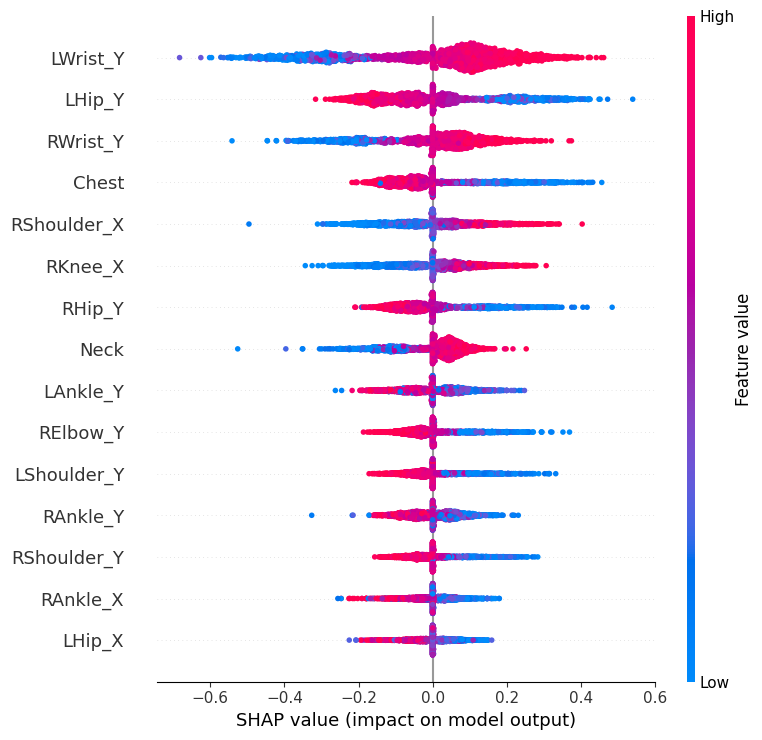

In [28]:
# SHAP 값을 2D 배열로 변환 (마지막 차원 제거)
shap_values_2d = shap_values.reshape(shap_values.shape[0], -1)  # 2D로 변환
X_double_test_2d = X_double_test.reshape(X_double_test.shape[0], -1)


# Summary plot 시각화
shap.summary_plot(shap_values_2d, X_double_test_2d, feature_names=feature_columns, max_display=15)

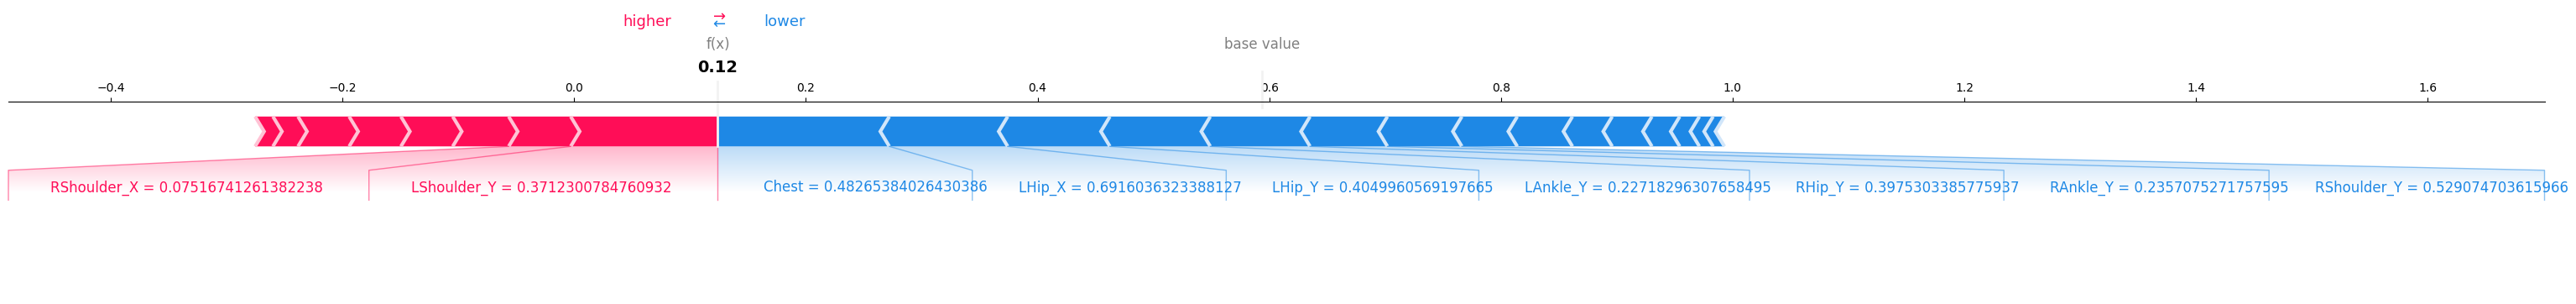

In [24]:
# 첫 번째 샘플에 대한 SHAP 값 및 특성 추출
shap_values_sample = shap_values_2d[0]
X_double_test_sample = X_double_test_2d[0]

# Force plot 시각화 (feature_names 추가)
shap.force_plot(explainer.expected_value, shap_values_sample, X_double_test_sample, 
                 matplotlib=True, figsize=(39, 3), feature_names=feature_columns)